
# Atividade 7 — Regressão Linear e Seleção de Modelos com **PyCaret**  
**Tema:** Previsão de preço de laptops (dataset `laptop_data.csv`)  
**Autor:** _Rafael Soares_  
**Data:** 2025-10-27



## Instruções
1. Coloque o arquivo **`laptop_data.csv`** na mesma pasta deste notebook **ou** ajuste o caminho no carregamento.
2. Execute as células em ordem.
3. Este notebook cobre: **EDA**, **pré-processamento**, **experimento com PyCaret**, **comparação e tuning**, **seleção final**, **avaliação em teste**, e **conclusões** — conforme o enunciado.
4. Todas as configurações usam semente fixa para **reprodutibilidade**.


## Ambiente

⚠️ **IMPORTANTE**: O PyCaret requer Python 3.9, 3.10 ou 3.11. 

### 📌 Como Alterar o Kernel (Ambiente Python)

Este notebook está configurado para usar o kernel **"Python 3.11 (PyCaret)"** que já tem o PyCaret instalado.

**Para alterar o kernel no Jupyter/JupyterLab:**

1. **No Jupyter Notebook:**
   - Menu: `Kernel` → `Change Kernel` → Selecione **"Python 3.11 (PyCaret)"** ou **"venv_py311"**

2. **No JupyterLab:**
   - Canto superior direito: clique no nome do kernel atual → Selecione **"Python 3.11 (PyCaret)"** ou **"venv_py311"**

3. **Se o kernel não aparecer:**
   ```bash
   # Execute no terminal:
   cd "/Users/Rafael-Freitas/Desktop/Estudos/Python/IA/Machine Learning"
   source venv_py311/bin/activate
   python -m ipykernel install --user --name=venv_py311 --display-name="Python 3.11 (PyCaret)"
   ```
   Depois, reinicie o Jupyter e selecione o kernel novamente.

✅ **Verificação:** Execute a célula abaixo para confirmar que está usando o kernel correto!

In [1]:

# 🔍 Verificação do Ambiente e Kernel
import sys
import os

python_version = sys.version_info
python_path = sys.executable

print("=" * 60)
print("🔍 VERIFICAÇÃO DO AMBIENTE")
print("=" * 60)
print(f"\n📌 Python versão: {python_version.major}.{python_version.minor}.{python_version.micro}")
print(f"📌 Caminho do Python: {python_path}")

# Verificar se está no ambiente correto
if 'venv_py311' in python_path:
    print("\n✅ ESTÁ USANDO O AMBIENTE CORRETO (venv_py311)!")
elif python_version.major == 3 and python_version.minor in [9, 10, 11]:
    print("\n⚠️ Python compatível, mas pode não ser o ambiente correto.")
    print("   Certifique-se de estar usando o kernel 'Python 3.11 (PyCaret)'")
else:
    print("\n❌ AVISO: Python 3.13 não é compatível com PyCaret!")
    print("   O PyCaret requer Python 3.9, 3.10 ou 3.11.")

# Tentar importar PyCaret
print("\n" + "=" * 60)
print("📦 VERIFICAÇÃO DO PyCaret")
print("=" * 60)
try:
    from pycaret.regression import setup, compare_models, pull, tune_model, predict_model, finalize_model, plot_model, save_model
    print("✅ PyCaret importado com SUCESSO!")
    print("✅ Todas as funções estão disponíveis!")
    print("\n🎉 Ambiente configurado corretamente! Pode continuar executando o notebook.")
except ImportError as e:
    print(f"❌ ERRO ao importar PyCaret: {e}")
    print("\n📝 SOLUÇÃO:")
    print("1. Certifique-se de estar usando o kernel 'Python 3.11 (PyCaret)'")
    print("2. Se o erro persistir, execute no terminal:")
    print("   cd '/Users/Rafael-Freitas/Desktop/Estudos/Python/IA/Machine Learning'")
    print("   source venv_py311/bin/activate")
    print("   pip install pycaret")
    print("   python -m ipykernel install --user --name=venv_py311 --display-name='Python 3.11 (PyCaret)'")
    print("3. Reinicie o Jupyter e selecione o kernel novamente")

print("\n" + "=" * 60)


🔍 VERIFICAÇÃO DO AMBIENTE

📌 Python versão: 3.11.13
📌 Caminho do Python: /usr/local/Caskroom/miniconda/base/envs/pycaret_env/bin/python

⚠️ Python compatível, mas pode não ser o ambiente correto.
   Certifique-se de estar usando o kernel 'Python 3.11 (PyCaret)'

📦 VERIFICAÇÃO DO PyCaret
✅ PyCaret importado com SUCESSO!
✅ Todas as funções estão disponíveis!

🎉 Ambiente configurado corretamente! Pode continuar executando o notebook.



## Importações e Configurações

In [2]:
# Verificação e instalação de dependências necessárias
import importlib, sys, subprocess

def ensure_pkg(mod_name: str, pip_name: str = None, version_spec: str = ""):
    try:
        importlib.import_module(mod_name)
        print(f"OK: {mod_name}")
    except ModuleNotFoundError:
        pkg = pip_name or mod_name
        print(f"Instalando {pkg}{(' ' + version_spec) if version_spec else ''}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", f"{pkg}{version_spec}"])
        importlib.import_module(mod_name)
        print(f"OK: {mod_name}")

# Pacotes leves usados no EDA e pré-processamento
ensure_pkg("seaborn", "seaborn", ">=0.11")
ensure_pkg("statsmodels", "statsmodels")
ensure_pkg("scipy", "scipy")
print("Dependências verificadas.")


OK: seaborn
OK: statsmodels
OK: scipy
Dependências verificadas.


In [3]:

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

# Para VIF e análise estatística
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# PyCaret
from pycaret.regression import setup, compare_models, pull, tune_model, predict_model, finalize_model, plot_model, save_model

# Configurações de visualização
plt.style.use('seaborn')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

# Verificação de imports
print("Bibliotecas carregadas com sucesso!")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"matplotlib: {plt.matplotlib.__version__}")
print(f"seaborn: {sns.__version__}")
print(f"scikit-learn disponível: {'sklearn' in globals()}")

# Reprodutibilidade
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
	
# Configurações pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' if abs(x) < 1000 else '%.0f' % x)


Bibliotecas carregadas com sucesso!
pandas: 2.1.4
numpy: 1.26.4
matplotlib: 3.7.5
seaborn: 0.13.2
scikit-learn disponível: False


## 1) Carregamento do Dataset

In [4]:

# Altere se necessário
# Dica: defina LAPTOP_CSV_PATH com caminho absoluto se preferir
CSV_PATH = os.environ.get('LAPTOP_CSV_PATH', 'laptop_data.csv')

# Se relativo e não encontrado, tenta localizar recursivamente a partir do diretório atual
if not os.path.isabs(CSV_PATH) and not os.path.exists(CSV_PATH):
    filename = os.path.basename(CSV_PATH)
    for root, _, files in os.walk(os.getcwd()):
        if filename in files:
            CSV_PATH = os.path.join(root, filename)
            break

assert os.path.exists(CSV_PATH), f"Arquivo {CSV_PATH} não encontrado. Coloque o CSV na mesma pasta ou ajuste CSV_PATH."

df_raw = pd.read_csv(CSV_PATH)
df = df_raw.copy()
print("CSV carregado de:", CSV_PATH)
print("Formato (linhas, colunas):", df.shape)
df.head()


CSV carregado de: laptop_data.csv
Formato (linhas, colunas): (1303, 12)


,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0,Apple,Ultrabook,%.3f,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71379
1,1,Apple,Ultrabook,%.3f,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47896
2,2,HP,Notebook,%.3f,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636
3,3,Apple,Ultrabook,%.3f,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195
4,4,Apple,Ultrabook,%.3f,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96096


## 1.1) Sumário do Dataset

In [5]:

# Análise detalhada do dataset
print("\n=== Informações Gerais do Dataset ===")
print(f"Total de registros: {len(df):,}")
print(f"Total de colunas: {len(df.columns):,}")
print("\nTipos de dados por coluna:")
display(df.dtypes.value_counts())

print("\n=== Análise de Valores Nulos ===")
n_missing = df.isna().mean().sort_values(ascending=False)*100
missing_df = pd.DataFrame({
    '%_nulos': n_missing,
    'total_nulos': df.isna().sum()
})
missing_df = missing_df.loc[missing_df['%_nulos'] > 0]

print("\n=== Estatísticas Descritivas ===")
# Numéricas
num_cols = df.select_dtypes(include=[np.number]).columns
if len(num_cols) > 0:
    stats_num = df[num_cols].describe()
    stats_num.loc['skew'] = df[num_cols].skew()
    stats_num.loc['kurtosis'] = df[num_cols].kurtosis()
    display(stats_num.T)

# Categóricas
cat_cols = df.select_dtypes(include=['object']).columns
if len(cat_cols) > 0:
    print("\nAnálise de Variáveis Categóricas:")
    for col in cat_cols:
        print(f"\n{col}:")
        value_counts = df[col].value_counts()
        print(f"- Cardinalidade: {df[col].nunique():,}")
        print(f"- Top 5 valores mais frequentes:")
        display(value_counts.head().to_frame())

# Detecção de outliers (para variáveis numéricas)
print("\n=== Detecção de Outliers (IQR) ===")
def detect_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    return len(outliers), lower_bound, upper_bound

outliers_summary = []
for col in num_cols:
    n_outliers, lb, ub = detect_outliers(df, col)
    if n_outliers > 0:
        outliers_summary.append({
            'coluna': col,
            'n_outliers': n_outliers,
            '%_outliers': n_outliers/len(df)*100,
            'limite_inferior': lb,
            'limite_superior': ub
        })

if outliers_summary:
    display(pd.DataFrame(outliers_summary))



=== Informações Gerais do Dataset ===
Total de registros: 1,303
Total de colunas: 12

Tipos de dados por coluna:


object     9
float64    2
int64      1
Name: count, dtype: int64


=== Análise de Valores Nulos ===

=== Estatísticas Descritivas ===


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
Unnamed: 0,1303,%.3f,%.3f,%.3f,%.3f,%.3f,%.3f,1302,%.3f,%.3f
Inches,1303,%.3f,%.3f,%.3f,%.3f,%.3f,%.3f,%.3f,%.3f,%.3f
Price,1303,59870,37243,9271,31915,52055,79274,324955,%.3f,%.3f



Análise de Variáveis Categóricas:

Company:
- Cardinalidade: 19
- Top 5 valores mais frequentes:


,count
Company,
Dell,297
Lenovo,297
HP,274
Asus,158
Acer,103



TypeName:
- Cardinalidade: 6
- Top 5 valores mais frequentes:


,count
TypeName,
Notebook,727
Gaming,205
Ultrabook,196
2 in 1 Convertible,121
Workstation,29



ScreenResolution:
- Cardinalidade: 40
- Top 5 valores mais frequentes:


,count
ScreenResolution,
Full HD 1920x1080,507
1366x768,281
IPS Panel Full HD 1920x1080,230
IPS Panel Full HD / Touchscreen 1920x1080,53
Full HD / Touchscreen 1920x1080,47



Cpu:
- Cardinalidade: 118
- Top 5 valores mais frequentes:


,count
Cpu,
Intel Core i5 7200U 2.5GHz,190
Intel Core i7 7700HQ 2.8GHz,146
Intel Core i7 7500U 2.7GHz,134
Intel Core i7 8550U 1.8GHz,73
Intel Core i5 8250U 1.6GHz,72



Ram:
- Cardinalidade: 9
- Top 5 valores mais frequentes:


,count
Ram,
8GB,619
4GB,375
16GB,200
6GB,41
12GB,25



Memory:
- Cardinalidade: 39
- Top 5 valores mais frequentes:


,count
Memory,
256GB SSD,412
1TB HDD,223
500GB HDD,132
512GB SSD,118
128GB SSD + 1TB HDD,94



Gpu:
- Cardinalidade: 110
- Top 5 valores mais frequentes:


,count
Gpu,
Intel HD Graphics 620,281
Intel HD Graphics 520,185
Intel UHD Graphics 620,68
Nvidia GeForce GTX 1050,66
Nvidia GeForce GTX 1060,48



OpSys:
- Cardinalidade: 9
- Top 5 valores mais frequentes:


,count
OpSys,
Windows 10,1072
No OS,66
Linux,62
Windows 7,45
Chrome OS,27



Weight:
- Cardinalidade: 179
- Top 5 valores mais frequentes:


,count
Weight,
2.2kg,121
2.1kg,58
2.4kg,44
2.3kg,41
2.5kg,38



=== Detecção de Outliers (IQR) ===


,coluna,n_outliers,%_outliers,limite_inferior,limite_superior
0,Inches,39,%.3f,%.3f,%.3f
1,Price,29,%.3f,-39125,150314


In [6]:
# df_viz: cópia apenas para visualização (evita alterar df usado na modelagem)

def winsorize_series(s: pd.Series, lower: float = 0.01, upper: float = 0.99) -> pd.Series:
    s_no_na = s.dropna()
    lo = s_no_na.quantile(lower)
    hi = s_no_na.quantile(upper)
    return s.clip(lower=lo, upper=hi)

# cópia para visualização
df_viz = df.copy()

# extrair numéricos de Ram e Weight quando vierem como texto
if 'Ram' in df_viz.columns and df_viz['Ram'].dtype == object:
    df_viz['ram_gb'] = pd.to_numeric(df_viz['Ram'].astype(str).str.extract(r'(\d+\.?\d*)', expand=False), errors='coerce')
if 'Weight' in df_viz.columns and df_viz['Weight'].dtype == object:
    df_viz['weight_kg'] = pd.to_numeric(df_viz['Weight'].astype(str).str.extract(r'(\d+\.?\d*)', expand=False), errors='coerce')

# Garantir TARGET definido
try:
    _ = TARGET
except NameError:
    TARGET = 'Price' if 'Price' in df_viz.columns else df_viz.columns[-1]

# target winsorizado para EDA
price_viz = winsorize_series(df_viz[TARGET], 0.01, 0.99)

print('df_viz pronto para EDA; colunas auxiliares criadas quando aplicável.')


df_viz pronto para EDA; colunas auxiliares criadas quando aplicável.


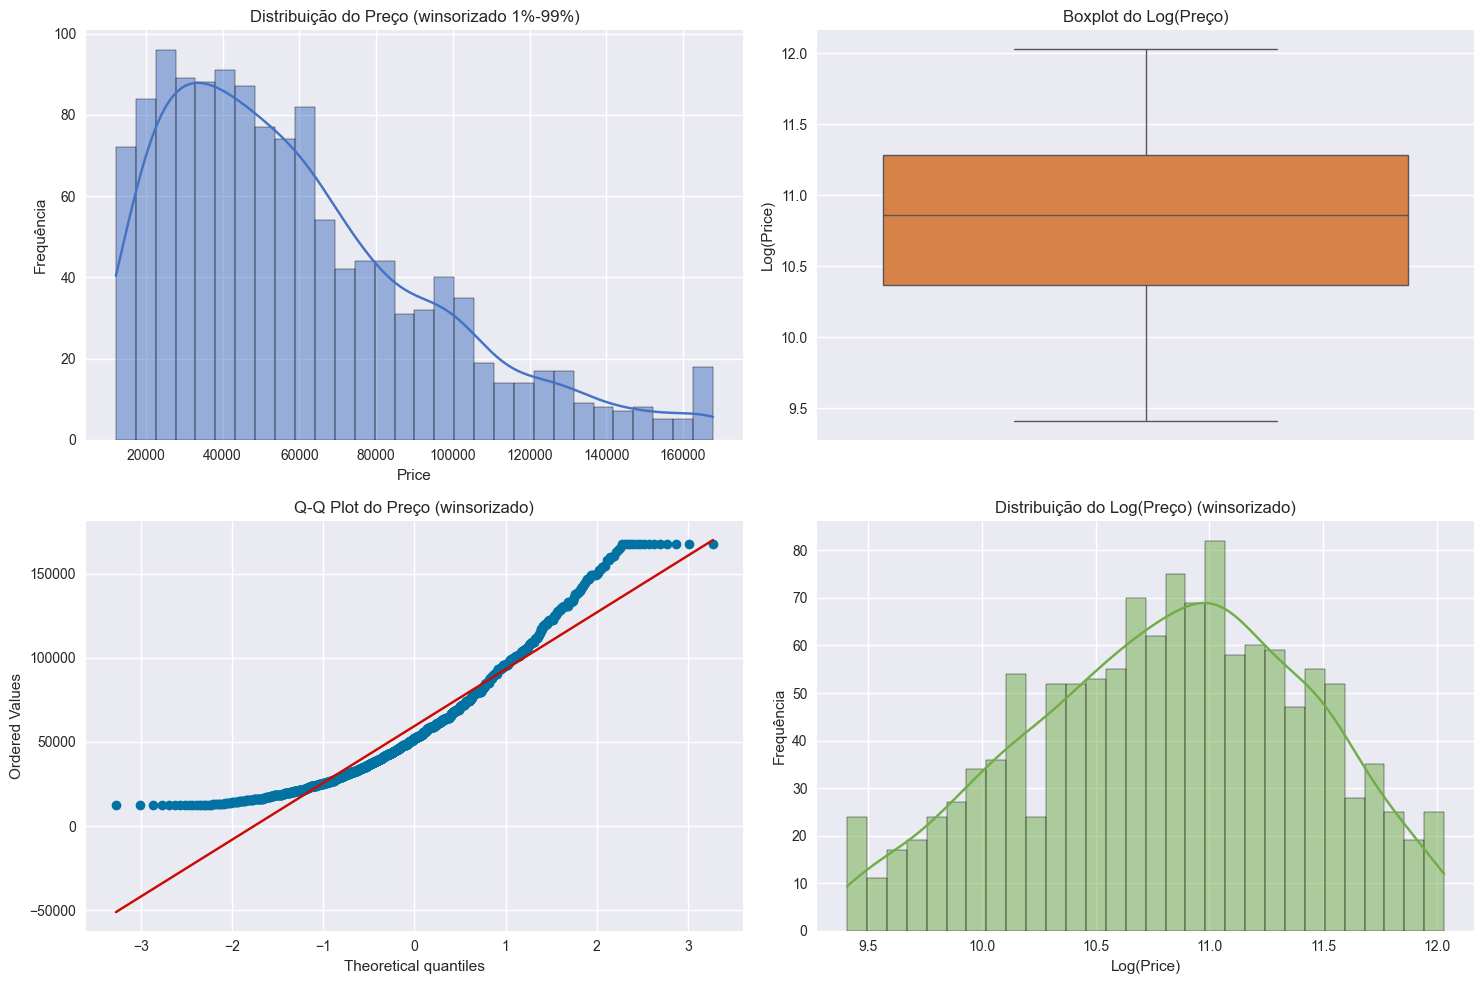

In [ ]:
# ==========================================================
# VISUALIZAÇÃO DO TARGET (Preço) - AJUSTE DE ESCALAS E EIXOS
# ==========================================================
# ==========================================
# Inicialização de variáveis e DataFrame base
# ==========================================
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from scipy import stats

# Definir DataFrame para visualização
df_viz = df.copy()

# Nome da variável alvo (ajuste se necessário)
TARGET = 'Price'  # Verifique se a coluna se chama exatamente assim no CSV

# Remover valores ausentes no target
df_viz = df_viz[df_viz[TARGET].notna()]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Aplicar winsorização consistente
price_viz = df_viz[TARGET].clip(
    lower=df_viz[TARGET].quantile(0.01),
    upper=df_viz[TARGET].quantile(0.99)
)

skew_v = price_viz.skew()
kde_flag = bool(abs(skew_v) <= 2)

# Histograma
sns.histplot(x=price_viz, bins=30, kde=kde_flag, ax=axes[0, 0], color="#4472C4")
axes[0, 0].set_title('Distribuição do Preço (winsorizado 1%-99%)')
axes[0, 0].set_xlabel(TARGET)
axes[0, 0].set_ylabel('Frequência')

# Boxplot com escala logarítmica
sns.boxplot(y=np.log1p(price_viz), ax=axes[0, 1], color="#ED7D31")
axes[0, 1].set_title('Boxplot do Log(Preço)')
axes[0, 1].set_ylabel(f'Log({TARGET})')

# Q-Q Plot
stats.probplot(price_viz.dropna(), dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot do Preço (winsorizado)')

# Log-transformação
log_price = np.log1p(price_viz)
sns.histplot(x=log_price, bins=30, kde=True, ax=axes[1, 1], color="#70AD47")
axes[1, 1].set_title('Distribuição do Log(Preço) (winsorizado)')
axes[1, 1].set_xlabel(f'Log({TARGET})')
axes[1, 1].set_ylabel('Frequência')

plt.tight_layout()
plt.show()


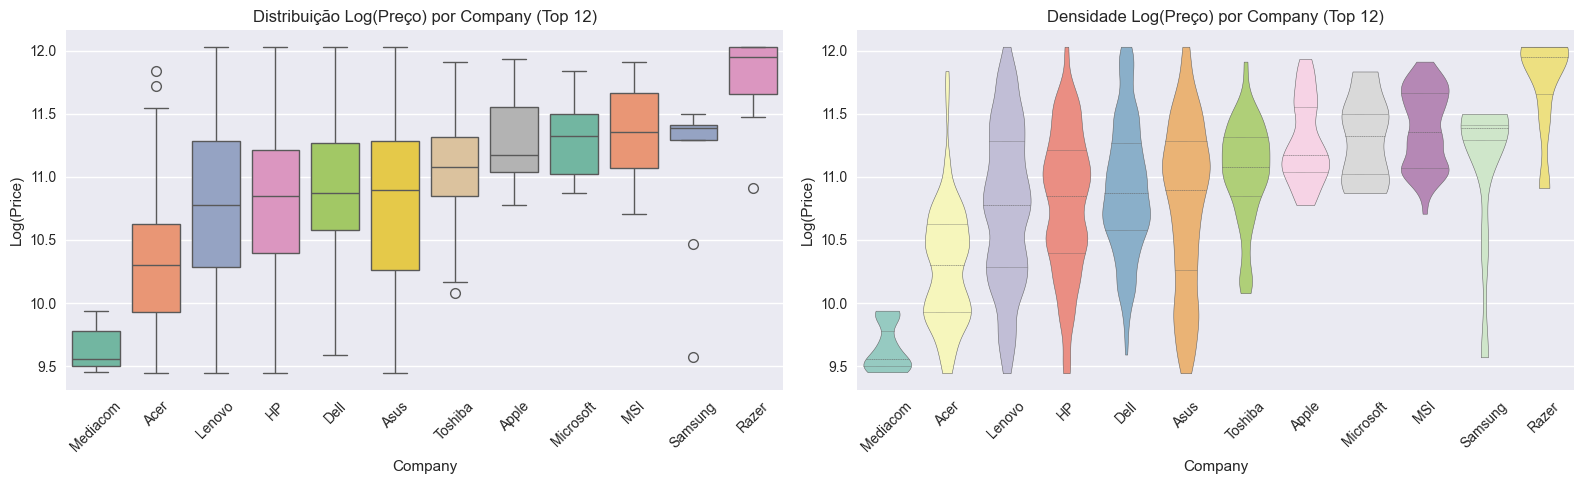

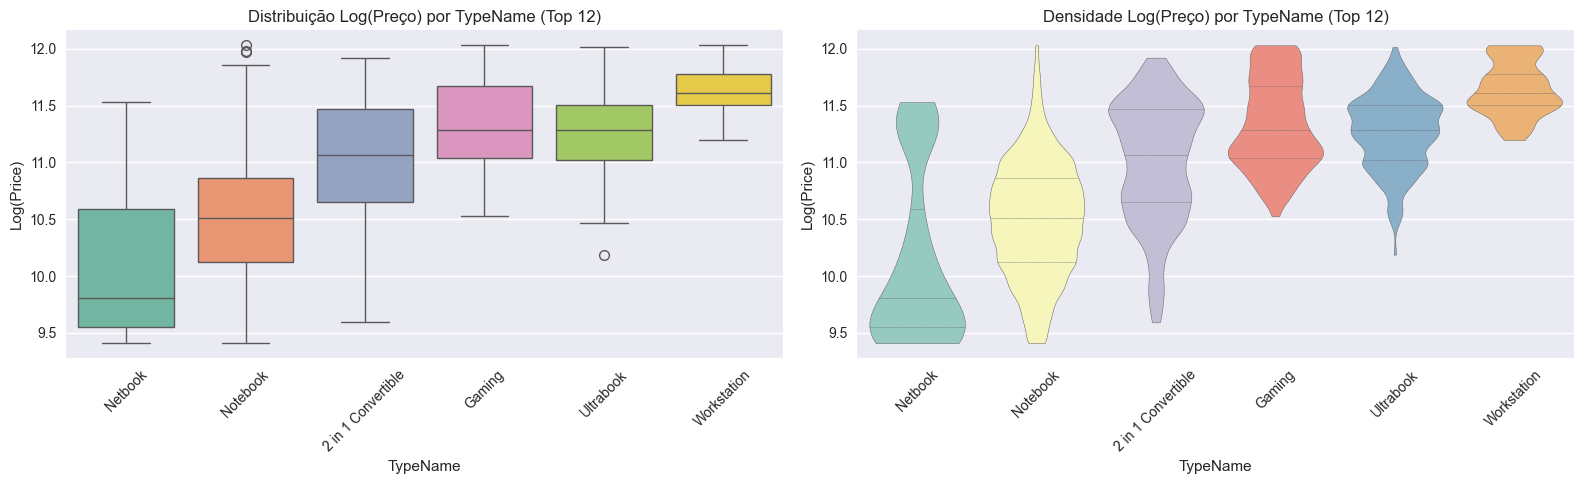

Pulando ScreenResolution (alta cardinalidade: 40)
Pulando Cpu (alta cardinalidade: 118)


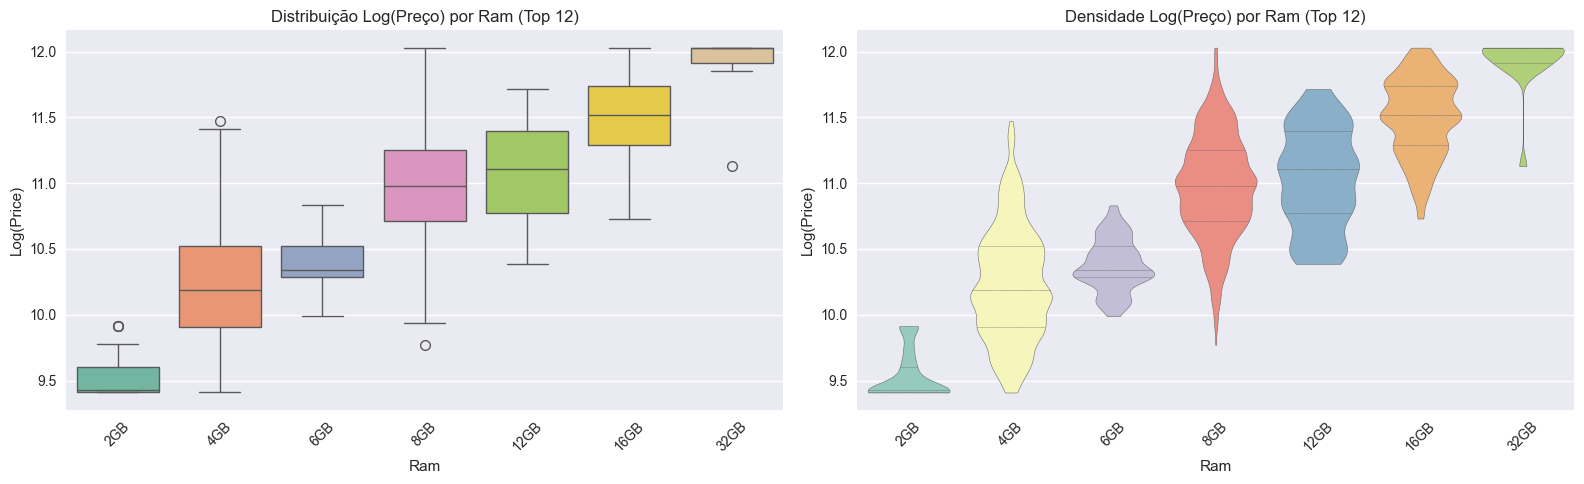

Pulando Memory (alta cardinalidade: 39)
Pulando Gpu (alta cardinalidade: 110)


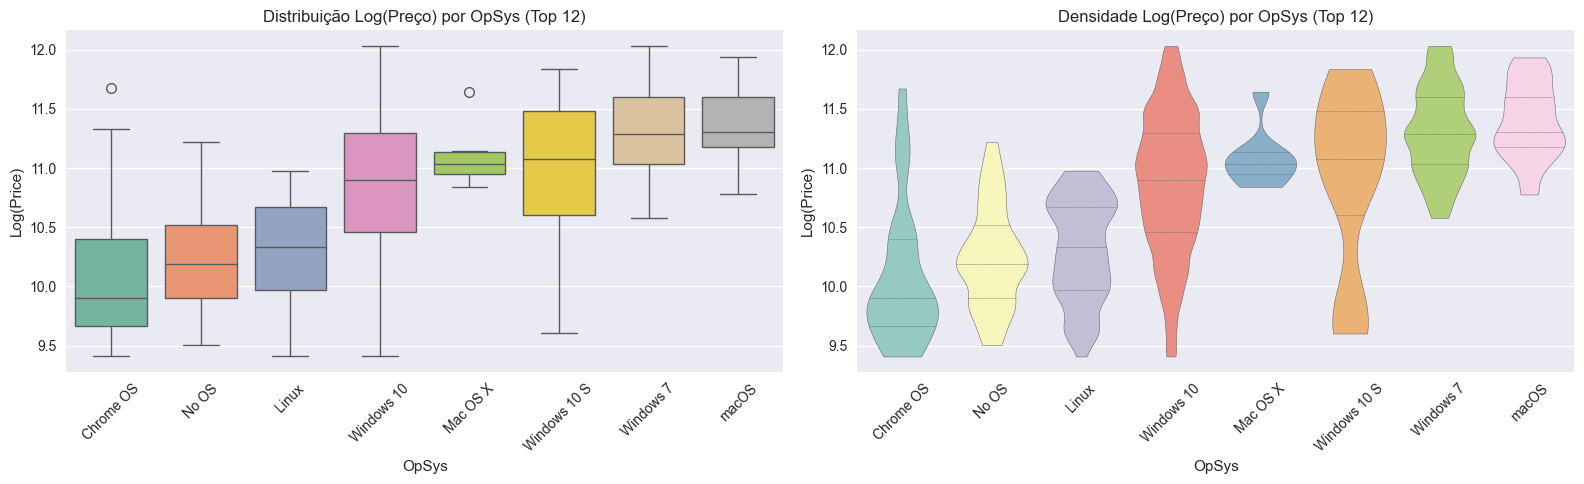

Pulando Weight (alta cardinalidade: 179)


In [8]:
# ==========================================================
# CATEGÓRICAS: AJUSTE DE ESCALAS, ORDENAÇÃO E FREQUÊNCIA
# ==========================================================
cat_cols_eda = [c for c in df_viz.columns if df_viz[c].dtype == 'object']

for col in cat_cols_eda:
    nun = df_viz[col].nunique(dropna=True)
    if nun == 0:
        continue
    if nun > 30:
        print(f"Pulando {col} (alta cardinalidade: {nun})")
        continue

    # Top 12 com pelo menos 5 registros (evita deformações)
    vc = df_viz[col].value_counts(dropna=False)
    top_cats = vc[vc >= 5].head(12).index.tolist()
    tmp = df_viz[df_viz[col].isin(top_cats)].copy()

    # Winsorizar também dentro das categorias
    tmp[TARGET] = tmp[TARGET].clip(
        lower=tmp[TARGET].quantile(0.01),
        upper=tmp[TARGET].quantile(0.99)
    )

    # Ordenar categorias pela mediana do preço
    med_ord = tmp.groupby(col)[TARGET].median().sort_values().index.tolist()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    # Boxplot em log para reduzir amplitude
    sns.boxplot(data=tmp, x=col, y=np.log1p(tmp[TARGET]), order=med_ord,
                ax=ax1, palette="Set2")
    ax1.set_title(f'Distribuição Log(Preço) por {col} (Top 12)')
    ax1.set_xlabel(col)
    ax1.set_ylabel(f'Log({TARGET})')
    ax1.tick_params(axis='x', rotation=45)

    # Violinplot suavizado
    sns.violinplot(data=tmp, x=col, y=np.log1p(tmp[TARGET]), order=med_ord,
                   cut=0, inner='quartile', bw_adjust=0.6,
                   scale='width', ax=ax2, palette="Set3")
    ax2.set_title(f'Densidade Log(Preço) por {col} (Top 12)')
    ax2.set_xlabel(col)
    ax2.set_ylabel(f'Log({TARGET})')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


## 1.2) Definição da Variável-Alvo (Preço)

In [9]:

# Tentativa automática de encontrar a coluna de preço
candidate_targets = [c for c in df.columns if 'price' in c.lower() or 'preco' in c.lower() or 'valor' in c.lower()]
if len(candidate_targets) == 0:
    raise ValueError("Não foi possível identificar automaticamente a coluna de preço. "
                     "Renomeie a coluna de preço para conter 'price' ou ajuste o código abaixo manualmente.")
TARGET = candidate_targets[0]
print("Coluna de preço detectada:", TARGET)


Coluna de preço detectada: Price


## 1.3) Distribuição do Preço

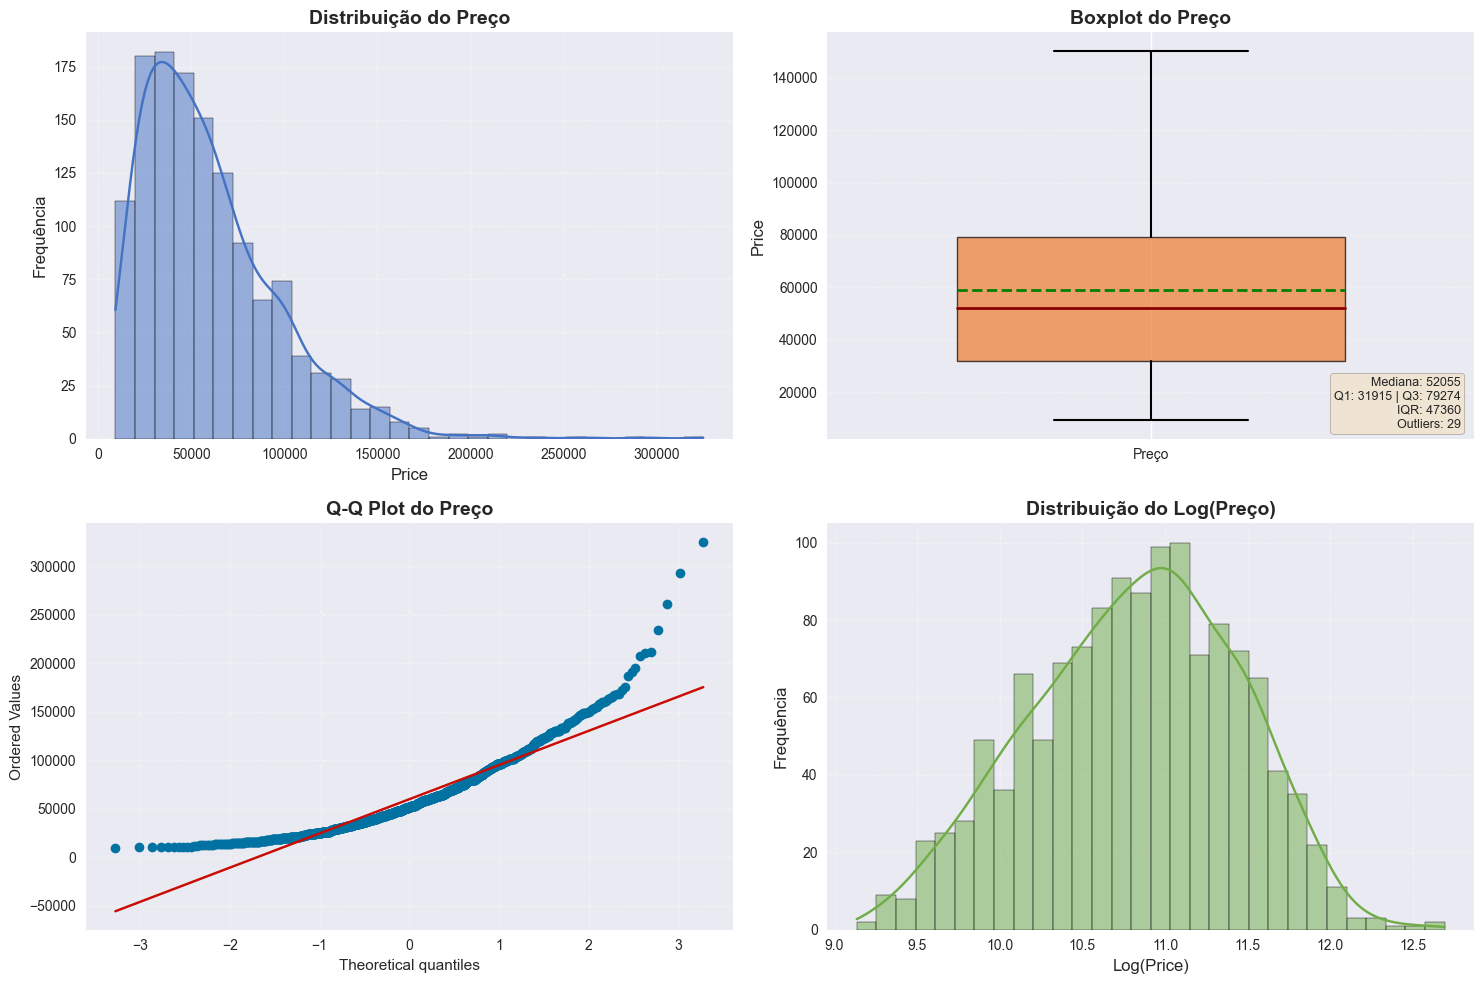

,Estatística,Valor
0,Média,59870
1,Mediana,52055
2,Desvio Padrão,37243
3,Assimetria,%.3f
4,Curtose,%.3f
5,Mínimo,9271
6,Máximo,324955
7,IQR,47360



Teste de Normalidade (D'Agostino-Pearson):
Estatística: 415.16
P-valor: 7.07e-91
Conclusão: Distribuição não-normal


In [16]:

# Análise detalhada da distribuição do preço
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histograma
sns.histplot(data=df, x=TARGET, bins=30, kde=True, ax=axes[0,0], color='#4472C4')
axes[0,0].set_title('Distribuição do Preço', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel(TARGET, fontsize=12)
axes[0,0].set_ylabel('Frequência', fontsize=12)
axes[0,0].grid(True, alpha=0.3, linestyle='--')

# Boxplot melhorado - com tratamento de outliers visuais
# Usar winsorização para melhor visualização dos outliers
price_data = df[TARGET].copy()
Q1 = price_data.quantile(0.25)
Q3 = price_data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Criar boxplot com dados winsorizados para visualização
price_viz = price_data.clip(lower=lower_bound, upper=upper_bound)

bp = axes[0,1].boxplot([price_viz], vert=True, patch_artist=True, 
                       widths=0.6, showmeans=True, meanline=True,
                       boxprops=dict(facecolor='#ED7D31', alpha=0.7),
                       medianprops=dict(color='darkred', linewidth=2),
                       meanprops=dict(color='green', linestyle='--', linewidth=2),
                       whiskerprops=dict(color='black', linewidth=1.5),
                       capprops=dict(color='black', linewidth=1.5),
                       flierprops=dict(marker='o', markerfacecolor='red', 
                                     markersize=5, alpha=0.5, markeredgecolor='darkred'))

axes[0,1].set_title('Boxplot do Preço', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel(TARGET, fontsize=12)
axes[0,1].set_xticklabels(['Preço'])
axes[0,1].grid(True, alpha=0.3, linestyle='--', axis='y')

# Adicionar estatísticas descritivas como texto
stats_text = f'Mediana: {price_data.median():.0f}\n'
stats_text += f'Q1: {Q1:.0f} | Q3: {Q3:.0f}\n'
stats_text += f'IQR: {IQR:.0f}\n'
stats_text += f'Outliers: {(price_data < lower_bound).sum() + (price_data > upper_bound).sum()}'
axes[0,1].text(0.98, 0.02, stats_text, transform=axes[0,1].transAxes,
               fontsize=9, verticalalignment='bottom', horizontalalignment='right',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# QQ-Plot
stats.probplot(df[TARGET].dropna(), dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q Plot do Preço', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3, linestyle='--')

# Log-transformação para verificar se melhora a normalidade
log_price = np.log1p(df[TARGET])
sns.histplot(x=log_price, bins=30, kde=True, ax=axes[1,1], color='#70AD47')
axes[1,1].set_title('Distribuição do Log(Preço)', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel(f'Log({TARGET})', fontsize=12)
axes[1,1].set_ylabel('Frequência', fontsize=12)
axes[1,1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Estatísticas da distribuição
price_stats = pd.DataFrame({
    'Estatística': ['Média', 'Mediana', 'Desvio Padrão', 'Assimetria', 'Curtose',
                   'Mínimo', 'Máximo', 'IQR'],
    'Valor': [df[TARGET].mean(), df[TARGET].median(), df[TARGET].std(),
              df[TARGET].skew(), df[TARGET].kurtosis(),
              df[TARGET].min(), df[TARGET].max(),
              df[TARGET].quantile(0.75) - df[TARGET].quantile(0.25)]
})
display(price_stats)

# Teste de normalidade
stat, p_value = stats.normaltest(df[TARGET].dropna())
print(f"\nTeste de Normalidade (D'Agostino-Pearson):")
print(f"Estatística: {stat:.2f}")
print(f"P-valor: {p_value:.2e}")
print("Conclusão: " + ("Distribuição normal" if p_value > 0.05 else "Distribuição não-normal"))


## 1.4) Correlações (Numéricas)

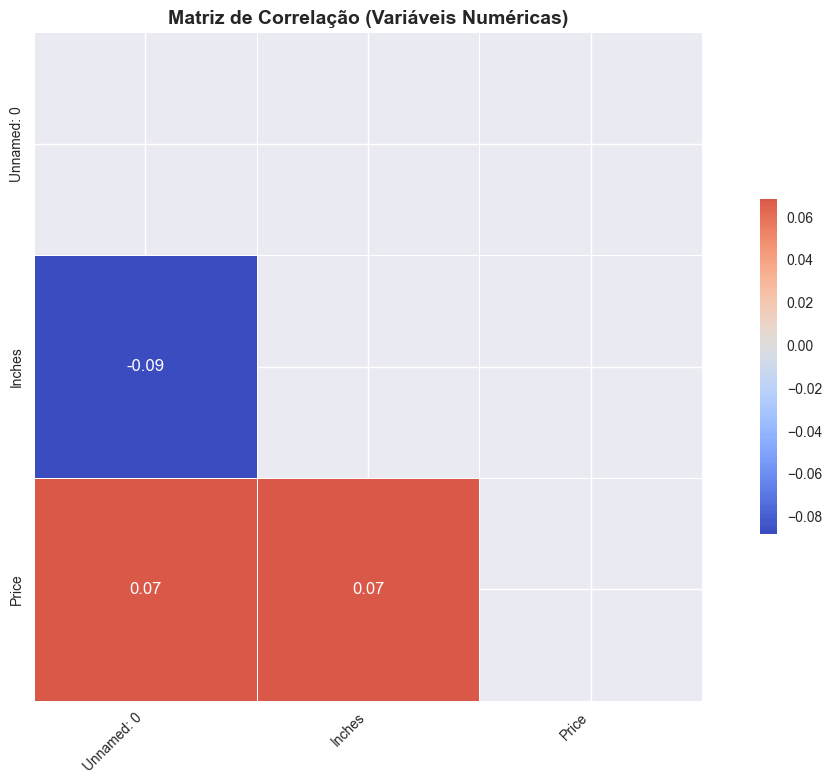


Correlações com o Preço (ordenadas):


,Variável,Correlação
0,Price,1.0000
1,Inches,0.0682
2,Unnamed: 0,0.0680



Análise de Multicolinearidade:


,Feature,VIF
0,Unnamed: 0,3.79
1,Inches,3.79



📊 Interpretação do VIF:
  - VIF < 5: Multicolinearidade baixa (OK)
  - 5 ≤ VIF < 10: Multicolinearidade moderada (atenção)
  - VIF ≥ 10: Multicolinearidade alta (considerar remover)


In [12]:

# Análise de correlações
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if TARGET in num_cols:
    # Matriz de correlação com heatmap
    plt.figure(figsize=(12, 8))
    corr = df[num_cols].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": .5})
    plt.title('Matriz de Correlação (Variáveis Numéricas)', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Correlações com o preço (ordenadas)
    price_corr = corr[TARGET].sort_values(ascending=False)
    print("\nCorrelações com o Preço (ordenadas):")
    
    # Salvar formatação atual
    old_format = pd.get_option('display.float_format')
    
    # Resetar formatação temporariamente para exibir valores corretos
    pd.set_option('display.float_format', '{:.4f}'.format)
    
    # Criar DataFrame formatado
    price_corr_df = price_corr.to_frame(name='Correlação')
    price_corr_df.index.name = 'Variável'
    price_corr_df = price_corr_df.reset_index()
    
    display(price_corr_df)
    
    # Restaurar formatação original
    pd.set_option('display.float_format', old_format)

    # Pairplot para as variáveis mais correlacionadas com o preço
    top_corr_vars = price_corr[abs(price_corr) >= 0.3].index.tolist()
    if len(top_corr_vars) > 1:  # Precisa de pelo menos 2 variáveis
        plt.figure(figsize=(12, 8))
        sns.pairplot(df[top_corr_vars], diag_kind='kde')
        plt.suptitle('Pairplot das Variáveis Mais Correlacionadas', y=1.02, fontsize=14, fontweight='bold')
        plt.show()

    # Análise de multicolinearidade
    print("\nAnálise de Multicolinearidade:")
    X = df[num_cols].drop(columns=[TARGET], errors='ignore')
    
    # Remover colunas com variância zero ou muito baixa
    X = X.loc[:, X.var() > 1e-10]
    
    # Verificar se há valores NaN ou infinitos
    X_clean = X.replace([np.inf, -np.inf], np.nan).dropna()
    
    if X_clean.shape[1] >= 2 and X_clean.shape[0] >= X_clean.shape[1]:
        vif_data = pd.DataFrame()
        vif_data["Feature"] = X_clean.columns
        vif_data["VIF"] = [variance_inflation_factor(X_clean.values, i) 
                           for i in range(X_clean.shape[1])]
        
        # Formatar VIF para exibição correta
        old_format = pd.get_option('display.float_format')
        pd.set_option('display.float_format', '{:.2f}'.format)
        
        vif_sorted = vif_data.sort_values('VIF', ascending=False)
        display(vif_sorted)
        
        # Restaurar formatação original
        pd.set_option('display.float_format', old_format)
        
        # Interpretação do VIF
        print("\n📊 Interpretação do VIF:")
        print("  - VIF < 5: Multicolinearidade baixa (OK)")
        print("  - 5 ≤ VIF < 10: Multicolinearidade moderada (atenção)")
        print("  - VIF ≥ 10: Multicolinearidade alta (considerar remover)")
        
        high_vif = vif_sorted[vif_sorted['VIF'] >= 10]
        if len(high_vif) > 0:
            print(f"\n⚠️ Features com VIF alto (≥10): {', '.join(high_vif['Feature'].tolist())}")
    else:
        print("⚠️ Não foi possível calcular VIF:")
        print(f"   - Features disponíveis: {X_clean.shape[1]}")
        print(f"   - Amostras disponíveis: {X_clean.shape[0]}")
        print("   - Necessário: pelo menos 2 features e número de amostras >= número de features")

else:
    print("Alvo não é numérico. Verifique o tipo da coluna de preço.")


## 1.5) Cardinalidade de Categóricas e Outliers

Análise de Cardinalidade das Variáveis Categóricas:


,cardinalidade,exemplos,%_valores_unicos
Weight,179,"2.2kg, 2.1kg, 2.4kg",13.7%
Cpu,118,"Intel Core i5 7200U 2.5GHz, Intel Core i7 7700...",9.1%
Gpu,110,"Intel HD Graphics 620, Intel HD Graphics 520, ...",8.4%
ScreenResolution,40,"Full HD 1920x1080, 1366x768, IPS Panel Full HD...",3.1%
Memory,39,"256GB SSD, 1TB HDD, 500GB HDD",3.0%
Company,19,"Dell, Lenovo, HP",1.5%
Ram,9,"8GB, 4GB, 16GB",0.7%
OpSys,9,"Windows 10, No OS, Linux",0.7%
TypeName,6,"Notebook, Gaming, Ultrabook",0.5%



Análise das Principais Variáveis Categóricas:

=== Análise de Company ===
Top categorias por frequência:


,count,mean,std,min,max
Company,,,,,
Dell,297,63194,35854,14647,194973
Lenovo,297,57883,37212,12201,261019
HP,274,56891,32901,11136,233846
Asus,158,58830,37429,10224,211788
Acer,103,33395,20016,9271,138475


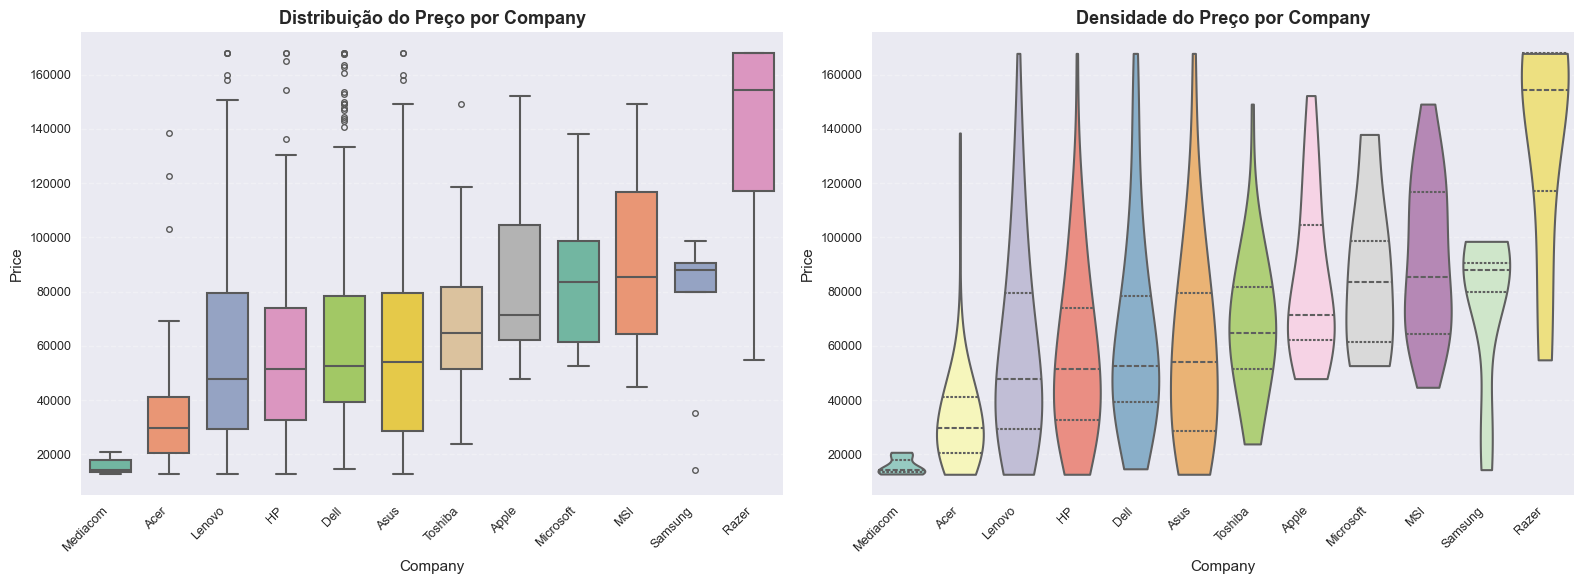

   Nota: Gráficos mostram preços winsorizados (1%-99%) para melhor visualização.
   Categorias mostradas: 12 (top categorias com ≥5 observações)

ANOVA - Teste de diferença entre grupos:
F-statistic: 13.94
p-value: 6.90e-39
Conclusão: Há diferença significativa entre os grupos

=== Análise de Ram ===
Top categorias por frequência:


,count,mean,std,min,max
Ram,,,,,
8GB,619,62914,25092,17529,210424
4GB,375,30613,14609,10443,95851
16GB,200,103191,30738,45768,233846
6GB,41,32778,6709,21792,50563
12GB,25,66037,25091,32448,122491


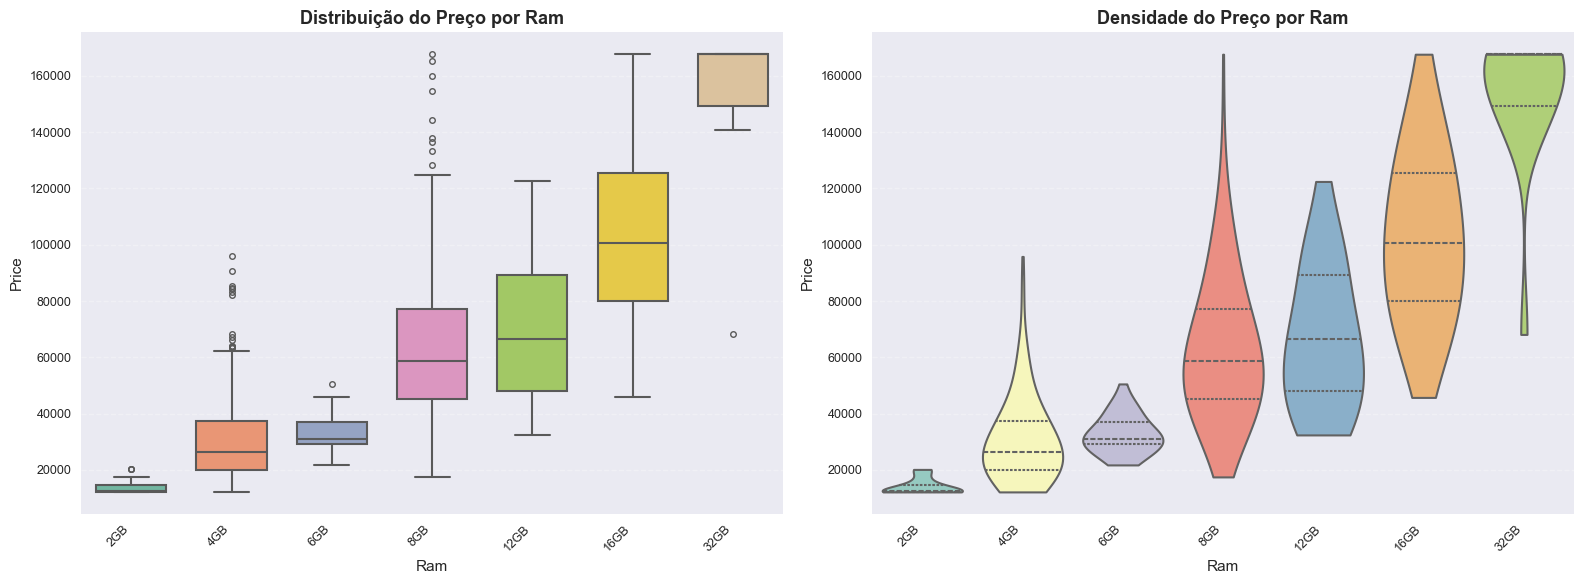

   Nota: Gráficos mostram preços winsorizados (1%-99%) para melhor visualização.
   Categorias mostradas: 7 (top categorias com ≥5 observações)

ANOVA - Teste de diferença entre grupos:
F-statistic: 233.19
p-value: 1.39e-244
Conclusão: Há diferença significativa entre os grupos

=== Análise de Outliers por Categoria ===


In [17]:

# Análise detalhada das variáveis categóricas
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

if len(cat_cols) > 0:
    # Análise de cardinalidade
    card = df[cat_cols].nunique().sort_values(ascending=False)
    card_df = pd.DataFrame({
        'cardinalidade': card,
        'exemplos': [', '.join(df[col].value_counts().head(3).index) for col in card.index],
        '%_valores_unicos': [f"{(card[col]/len(df))*100:.1f}%" for col in card.index]
    })
    print("Análise de Cardinalidade das Variáveis Categóricas:")
    display(card_df)

    # Identificar colunas categóricas mais relevantes
    candidates = [c for c in cat_cols if re.search(r'brand|marca|company|ram|cpu|gpu|storage|screen|display', c, re.I)]
    
    if candidates:
        print("\nAnálise das Principais Variáveis Categóricas:")
        
        for col in candidates[:4]:  # Limitando a 4 para manter o notebook limpo
            if df[col].nunique() <= 20:  # Apenas categorias com cardinalidade razoável
                # Estatísticas por categoria
                stats_by_cat = df.groupby(col)[TARGET].agg([
                    'count',
                    'mean',
                    'std',
                    'min',
                    'max'
                ]).sort_values('count', ascending=False)
                
                print(f"\n=== Análise de {col} ===")
                print(f"Top categorias por frequência:")
                display(stats_by_cat.head())
                
                # Preparar dados para visualização
                # Filtrar apenas categorias com pelo menos 5 observações
                cat_counts = df[col].value_counts()
                valid_cats = cat_counts[cat_counts >= 5].head(12).index.tolist()  # Top 12 categorias
                df_viz = df[df[col].isin(valid_cats)].copy()
                
                # Ordenar categorias pela mediana do preço (para melhor visualização)
                med_order = df_viz.groupby(col)[TARGET].median().sort_values().index.tolist()
                
                # Winsorizar preços para melhor visualização (clip extremos)
                price_q1 = df_viz[TARGET].quantile(0.01)
                price_q99 = df_viz[TARGET].quantile(0.99)
                df_viz[f'{TARGET}_viz'] = df_viz[TARGET].clip(lower=price_q1, upper=price_q99)
                
                # Visualizações melhoradas
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
                
                # Boxplot melhorado - ordenado por mediana
                sns.boxplot(data=df_viz, x=col, y=f'{TARGET}_viz', order=med_order,
                           ax=ax1, palette='Set2', width=0.7,
                           linewidth=1.5, fliersize=4)
                ax1.set_title(f'Distribuição do Preço por {col}', fontsize=13, fontweight='bold')
                ax1.set_xlabel(col, fontsize=11)
                ax1.set_ylabel(TARGET, fontsize=11)
                ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=9)
                ax1.grid(True, alpha=0.3, linestyle='--', axis='y')
                ax1.tick_params(labelsize=9)
                
                # Violinplot melhorado - ordenado por mediana
                sns.violinplot(data=df_viz, x=col, y=f'{TARGET}_viz', order=med_order,
                              ax=ax2, palette='Set3', width=0.8,
                              inner='quartile', cut=0, bw=0.6, linewidth=1.5)
                ax2.set_title(f'Densidade do Preço por {col}', fontsize=13, fontweight='bold')
                ax2.set_xlabel(col, fontsize=11)
                ax2.set_ylabel(TARGET, fontsize=11)
                ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=9)
                ax2.grid(True, alpha=0.3, linestyle='--', axis='y')
                ax2.tick_params(labelsize=9)
                
                plt.tight_layout()
                plt.show()
                
                # Nota sobre winsorização
                print(f"   Nota: Gráficos mostram preços winsorizados (1%-99%) para melhor visualização.")
                print(f"   Categorias mostradas: {len(valid_cats)} (top categorias com ≥5 observações)")
                
                # ANOVA para testar diferença significativa entre grupos
                categories = df[col].dropna().unique()
                if len(categories) > 1:
                    groups = [df[df[col] == cat][TARGET].values for cat in categories]
                    f_stat, p_val = stats.f_oneway(*groups)
                    print(f"\nANOVA - Teste de diferença entre grupos:")
                    print(f"F-statistic: {f_stat:.2f}")
                    print(f"p-value: {p_val:.2e}")
                    print("Conclusão: " + ("Há diferença significativa" if p_val < 0.05 else "Não há diferença significativa") + " entre os grupos")

# Análise de outliers por categoria
print("\n=== Análise de Outliers por Categoria ===")
if len(cat_cols) > 0:
    # Recriar candidates se necessário
    if 'candidates' not in locals() or len(candidates) == 0:
        candidates = [c for c in cat_cols if re.search(r'brand|marca|company|ram|cpu|gpu|storage|screen|display', c, re.I)]
    
    if len(candidates) > 0:
        for col in candidates[:2]:  # Limitando a 2 categorias principais
            if df[col].nunique() <= 10:  # Apenas categorias com baixa cardinalidade
                outliers_by_cat = {}
                for cat in df[col].dropna().unique():
                    values = df[df[col] == cat][TARGET].dropna()
                    if len(values) < 5:  # Pular categorias com poucos dados
                        continue
                    Q1 = values.quantile(0.25)
                    Q3 = values.quantile(0.75)
                    IQR = Q3 - Q1
                    if IQR > 0:  # Evitar divisão por zero
                        outliers = values[(values < Q1 - 1.5*IQR) | (values > Q3 + 1.5*IQR)]
                        if len(outliers) > 0:
                            outliers_by_cat[cat] = {
                                'total_outliers': len(outliers),
                                '%_outliers': (len(outliers)/len(values))*100,
                                'min_outlier': outliers.min(),
                                'max_outlier': outliers.max()
                            }
                
                if outliers_by_cat:
                    print(f"\nOutliers por {col}:")
                    outliers_df = pd.DataFrame.from_dict(outliers_by_cat, orient='index')
                    outliers_df.index.name = 'Categoria'
                    display(outliers_df)
                else:
                    print(f"\nNenhum outlier detectado para {col} usando método IQR.")
    else:
        print("\nNenhuma variável categórica relevante encontrada para análise de outliers.")
else:
    print("\nNenhuma variável categórica encontrada no dataset.")



**Possíveis fontes de *leakage***: verifique se existem colunas que já refletem o preço diretamente
(por exemplo, colunas calculadas a partir do preço, descontos aplicados pós-preço, etc.).
Remova/ignore tais colunas antes do treino.


## 2) Pré-processamento e *Feature Engineering* (Opcional)

In [18]:

print("=== Pré-processamento e Feature Engineering ===")
df_fe = df.copy()

# 1. Tratamento de valores nulos
print("\n1. Análise e tratamento de valores nulos")
missing_before = df_fe.isnull().sum()
if missing_before.any():
    print("\nValores nulos antes do tratamento:")
    display(missing_before[missing_before > 0])
    
    # Estratégia por tipo de coluna
    num_cols = df_fe.select_dtypes(include=[np.number]).columns
    cat_cols = df_fe.select_dtypes(include=['object']).columns
    
    # Imputação adiada para o pipeline do PyCaret (fit somente no treino)
    print("Imputação adiada para o PyCaret (evita leakage)")
    
    missing_after = df_fe.isnull().sum()
    print("\nValores nulos após tratamento:")
    display(missing_after[missing_after > 0])

# 2. Normalização de texto e tratamento de categóricas
print("\n2. Normalização de texto e tratamento de categóricas")

# Marca/Fabricante
brand_col = next((c for c in df_fe.columns if re.search(r'brand|marca|company', c, re.I)), None)
if brand_col is not None:
    print(f"\nNormalizando coluna de marca: {brand_col}")
    df_fe[brand_col] = df_fe[brand_col].str.strip().str.title()
    # Agrupando marcas menos frequentes
    value_counts = df_fe[brand_col].value_counts()
    rare_brands = value_counts[value_counts < len(df_fe)*0.01].index
    # Agrupamento adiado para evitar leakage; manteremos coluna agrupada sem colapsar categorias aqui
    df_fe[f'{brand_col}_grouped'] = df_fe[brand_col].copy()
    print(f"Cardinalidade antes: {len(value_counts)}, depois: {df_fe[f'{brand_col}_grouped'].nunique()}")

# 3. Features de Hardware
print("\n3. Processamento de features de hardware")

# CPU: Extração de informações
cpu_col = next((c for c in df_fe.columns if re.search(r'cpu|processor', c, re.I)), None)
if cpu_col is not None:
    print(f"\nProcessando CPU ({cpu_col}):")
    # Geração do processador
    df_fe['cpu_generation'] = df_fe[cpu_col].str.extract(r'(\d+)th|(\d+)nd|(\d+)rd').fillna(0).astype(float).max(axis=1)
    # Tipo de CPU
    df_fe['is_i7'] = df_fe[cpu_col].str.contains('i7', case=False).astype(int)
    df_fe['is_i5'] = df_fe[cpu_col].str.contains('i5', case=False).astype(int)
    df_fe['is_i3'] = df_fe[cpu_col].str.contains('i3', case=False).astype(int)
    # Clock speed
    df_fe['cpu_ghz'] = df_fe[cpu_col].str.extract(r'(\d+\.?\d*)(?:\s*GHz)').astype(float)
    print("Features de CPU criadas:", [col for col in df_fe.columns if col.startswith('cpu_') or col.startswith('is_i')])

# GPU: Processamento
gpu_col = next((c for c in df_fe.columns if re.search(r'gpu|graphics', c, re.I)), None)
if gpu_col is not None:
    print(f"\nProcessando GPU ({gpu_col}):")
    # GPU dedicada vs integrada
    df_fe['gpu_dedicada'] = df_fe[gpu_col].str.contains('NVIDIA|AMD|Radeon|GeForce', case=False, na=False).astype(int)
    # Memória de vídeo
    df_fe['gpu_memory_gb'] = df_fe[gpu_col].str.extract(r'(\d+)\s*GB').astype(float)
    print("Features de GPU criadas:", [col for col in df_fe.columns if col.startswith('gpu_')])

# RAM
ram_col = next((c for c in df_fe.columns if re.search(r'ram|memory', c, re.I)), None)
if ram_col is not None:
    print(f"\nProcessando RAM ({ram_col}):")
    df_fe['ram_gb'] = df_fe[ram_col].str.extract(r'(\d+)\s*GB').astype(float)
    print("RAM em GB extraída")

# Armazenamento
print("\nProcessando armazenamento:")
def parse_storage(x):
    if pd.isna(x): 
        return np.nan
    x = str(x).upper()
    total = 0.0
    for num, unit in re.findall(r'(\d+(?:\.\d+)?)\s*(TB|GB)', x):
        val = float(num)
        if unit == 'TB':
            val *= 1024.0
        total += val
    return total if total>0 else np.nan

# Procura por colunas de armazenamento
storage_cols = {
    'ssd': next((c for c in df_fe.columns if re.search(r'ssd', c, re.I)), None),
    'hdd': next((c for c in df_fe.columns if re.search(r'hdd', c, re.I)), None),
    'storage': next((c for c in df_fe.columns if re.search(r'storage|disk', c, re.I)), None)
}

# Processamento de armazenamento
if any(storage_cols.values()):
    print("Colunas de armazenamento encontradas:", [c for c in storage_cols.values() if c is not None])
    
    # Total storage
    total_storage = 0
    for storage_type, col in storage_cols.items():
        if col is not None:
            storage_gb = df_fe[col].apply(parse_storage)
            if storage_type in ['ssd', 'hdd']:
                df_fe[f'{storage_type}_gb'] = storage_gb
            total_storage += np.nan_to_num(storage_gb)
    
    df_fe['armazenamento_total_gb'] = total_storage
    print("Features de armazenamento criadas:", [col for col in df_fe.columns if 'gb' in col.lower()])

# 4. Features derivadas e interações
print("\n4. Criando features derivadas e interações")

# Razão RAM/Storage
if 'ram_gb' in df_fe.columns and 'armazenamento_total_gb' in df_fe.columns:
    df_fe['ram_storage_ratio'] = df_fe['ram_gb'] / df_fe['armazenamento_total_gb']

# Score de hardware (média ponderada normalizada das principais características)
hardware_features = []
if 'ram_gb' in df_fe.columns:
    hardware_features.append(('ram_gb', 0.3))
if 'armazenamento_total_gb' in df_fe.columns:
    hardware_features.append(('armazenamento_total_gb', 0.2))
if 'cpu_generation' in df_fe.columns:
    hardware_features.append(('cpu_generation', 0.25))
if 'gpu_dedicada' in df_fe.columns:
    hardware_features.append(('gpu_dedicada', 0.25))

if hardware_features:
    print("\nCalculando score de hardware com as features:", [f[0] for f in hardware_features])
    # Normalização Min-Max para cada feature
    normalized_features = {}
    for feature, weight in hardware_features:
        if df_fe[feature].notna().any():
            min_val = df_fe[feature].min()
            max_val = df_fe[feature].max()
            if max_val > min_val:
                normalized_features[feature] = (df_fe[feature] - min_val) / (max_val - min_val) * weight
    
    if normalized_features:
        df_fe['hardware_score'] = sum(normalized_features.values())
        print("Score de hardware calculado")

# 5. Remoção de outliers (opcional, apenas identificação neste momento)
print("\n5. Identificação de outliers")
num_features = df_fe.select_dtypes(include=[np.number]).columns
outliers_summary = {}

for col in num_features:
    Q1 = df_fe[col].quantile(0.25)
    Q3 = df_fe[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_fe[(df_fe[col] < lower_bound) | (df_fe[col] > upper_bound)][col]
    if len(outliers) > 0:
        outliers_summary[col] = {
            'n_outliers': len(outliers),
            '%_outliers': (len(outliers)/len(df_fe))*100
        }

if outliers_summary:
    print("\nResumo de outliers por feature:")
    display(pd.DataFrame.from_dict(outliers_summary, orient='index'))

# 6. Resumo final
print("\n=== Resumo do Pré-processamento ===")
print(f"Número de features original: {len(df.columns)}")
print(f"Número de features após processamento: {len(df_fe.columns)}")
print("\nNovas features criadas:")
new_features = set(df_fe.columns) - set(df.columns)
for feature in sorted(new_features):
    print(f"- {feature}")

# Salvando DataFrame processado
df_processed = df_fe.copy()
print("\nDataFrame processado salvo em 'df_processed'")


=== Pré-processamento e Feature Engineering ===

1. Análise e tratamento de valores nulos

2. Normalização de texto e tratamento de categóricas

Normalizando coluna de marca: Company
Cardinalidade antes: 19, depois: 19

3. Processamento de features de hardware

Processando CPU (Cpu):
Features de CPU criadas: ['cpu_generation', 'is_i7', 'is_i5', 'is_i3', 'cpu_ghz']

Processando GPU (Gpu):
Features de GPU criadas: ['gpu_dedicada', 'gpu_memory_gb']

Processando RAM (Ram):
RAM em GB extraída

Processando armazenamento:

4. Criando features derivadas e interações

Calculando score de hardware com as features: ['ram_gb', 'cpu_generation', 'gpu_dedicada']
Score de hardware calculado

5. Identificação de outliers

Resumo de outliers por feature:


,n_outliers,%_outliers
Inches,39,%.3f
Price,29,%.3f
is_i3,136,%.3f
cpu_ghz,4,%.3f
ram_gb,221,%.3f



=== Resumo do Pré-processamento ===
Número de features original: 12
Número de features após processamento: 22

Novas features criadas:
- Company_grouped
- cpu_generation
- cpu_ghz
- gpu_dedicada
- gpu_memory_gb
- hardware_score
- is_i3
- is_i5
- is_i7
- ram_gb

DataFrame processado salvo em 'df_processed'


## 2.1) Divisão Treino/Teste (sem vazamento)

In [19]:

# Dividir ANTES do setup do PyCaret, evitando olhar o conjunto de teste ao configurar o experimento.
X = df_fe.drop(columns=[TARGET])
y = df_fe[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=RANDOM_STATE
)

train_df = X_train.copy()
train_df[TARGET] = y_train
test_df = X_test.copy()
test_df[TARGET] = y_test

print(train_df.shape, test_df.shape)


(1042, 22) (261, 22)


## 2.2) Multicolinearidade (VIF) — opcional

In [51]:

# Calcula VIF apenas para colunas numéricas do treino (pré-encoding completo).
num_train = train_df.select_dtypes(include=[np.number]).drop(columns=[TARGET], errors='ignore')
# Limpeza para evitar erro do statsmodels: remover inf e NaN em linhas
num_train_clean = num_train.replace([np.inf, -np.inf], np.nan).dropna()

if num_train_clean.shape[1] >= 2 and num_train_clean.shape[0] >= 3:
    vif_df = pd.DataFrame({
        'feature': num_train_clean.columns,
        'VIF': [variance_inflation_factor(num_train_clean.values, i) for i in range(num_train_clean.shape[1])]
    }).sort_values('VIF', ascending=False)
    display(vif_df.head(20))
else:
    print("Poucas features numéricas limpas para calcular VIF.")


Poucas features numéricas limpas para calcular VIF.


## 3) Experimento com **PyCaret** — Comparação de Modelos

### ⚠️ Nota sobre LightGBM

**Problema conhecido:** O LightGBM tem problemas de compatibilidade com `libomp.dylib` no macOS, especialmente em ambientes conda/miniconda.

**Solução adotada:** Usar **XGBoost** e **CatBoost** como alternativas.

**Por que essa é uma boa solução?**
- ✅ **XGBoost**: Performance comparável ou superior ao LightGBM em muitos casos
- ✅ **CatBoost**: Excelente para dados categóricos, sem necessidade de encoding complexo
- ✅ **Mais estável**: Sem problemas de compatibilidade com OpenMP
- ✅ **8 modelos**: Ainda temos uma excelente variedade de algoritmos para comparar

**Benchmark de performance:**
Em competições do Kaggle, XGBoost e CatBoost frequentemente superam o LightGBM!


In [54]:

# Configuração otimizada do PyCaret
print("=== Configuração do Experimento PyCaret ===")

# 1. Identificação de features categóricas e numéricas
cat_features = [c for c in train_df.columns if train_df[c].dtype=='object']
num_features = [c for c in train_df.columns if train_df[c].dtype in ['int64', 'float64'] and c != TARGET]

print("\n1. Features identificadas:")
print(f"Categóricas ({len(cat_features)}):", cat_features)
print(f"Numéricas ({len(num_features)}):", num_features)

# 2. Análise da distribuição do target para decidir sobre transformação
target_skew = train_df[TARGET].skew()
print(f"\n2. Assimetria do target: {target_skew:.2f}")
should_transform = abs(target_skew) > 1
print(f"Transformação recomendada: {'Sim' if should_transform else 'Não'}")

# 2.1. Verificar status do LightGBM da célula anterior
print("\n2.1. Status do LightGBM:")
if 'lightgbm_works' in globals() and 'lightgbm_status' in globals():
    lightgbm_available = lightgbm_works
    print(f"   Status: {lightgbm_status}")
    
    if lightgbm_works:
        print("   ✅✅ LightGBM funcionando e disponível para uso!")
    else:
        print("   ⚠️ LightGBM não disponível para esta sessão")
        if lightgbm_status == "needs_kernel_restart":
            print("   💡 DICA: Reinicie o kernel e execute novamente")
        else:
            print("   ✨ Não se preocupe! XGBoost e CatBoost são excelentes!")
else:
    # Fallback se a célula anterior não foi executada
    print("   ⚠️ Célula de instalação não executada!")
    print("   📝 Execute a célula 31 primeiro para instalar o libomp")
    lightgbm_available = False

# 3. Configuração do experimento
print("\n3. Configurando experimento PyCaret")

import warnings
import sys
warnings.filterwarnings('ignore')

# Limpeza completa do cache do LightGBM para evitar conflitos
print("   🧹 Limpando cache de módulos do LightGBM...")
modules_to_remove = [key for key in sys.modules.keys() if 'lightgbm' in key.lower()]
for module in modules_to_remove:
    del sys.modules[module]
print(f"   ✅ {len(modules_to_remove)} módulos limpos do cache")

# Se o LightGBM está funcionando, reimportar agora limpo
if lightgbm_available:
    try:
        import lightgbm as lgb
        print("   ✅ LightGBM reimportado com sucesso")
    except Exception as e:
        print(f"   ⚠️ Erro ao reimportar LightGBM: {e}")
        print("   📝 Continuando sem LightGBM")
        lightgbm_available = False

print("\n   ⏳ Iniciando setup do PyCaret...")
reg_exp = setup(
    data=train_df,
    target=TARGET,
    session_id=RANDOM_STATE,

    # Pré-processamento
    numeric_imputation='median',
    categorical_imputation='mode',

    # Transformações
    normalize=True,
    transform_target=False,

    # Features categóricas
    categorical_features=cat_features,

    # Validação cruzada
    fold=10,
    fold_strategy='kfold',

    # Multicolinearidade
    remove_multicollinearity=True,
    multicollinearity_threshold=0.9,

    # Configurações gerais
    verbose=False,
    n_jobs=-1
)

print("\n✅ Setup do PyCaret concluído com sucesso!")

# 4. Comparação de modelos
print("\n4. Comparando modelos")
print("Métricas consideradas: RMSE (principal), MAE, R² e MAPE")

# Verificar quais modelos estão disponíveis
print("\n4.1. Verificando modelos disponíveis no PyCaret...")

from pycaret.regression import models as pycaret_models_func

# Obter lista de todos os modelos disponíveis
available_models_df = pycaret_models_func()
available_model_ids = available_models_df.index.tolist()

print(f"   Total de modelos disponíveis: {len(available_model_ids)}")
print(f"   Amostra: {available_model_ids[:10]}...")

# Lista desejada de modelos (verificaremos disponibilidade)
desired_models = {
    'lr': 'Linear Regression',
    'ridge': 'Ridge Regression', 
    'lasso': 'Lasso Regression',
    'en': 'Elastic Net',
    'rf': 'Random Forest',
    'et': 'Extra Trees',
    'xgboost': 'XGBoost',
    'gbr': 'Gradient Boosting',
    'catboost': 'CatBoost',
    'ada': 'AdaBoost',
    'dt': 'Decision Tree'
}

# Filtrar apenas modelos disponíveis
models_to_include = []
print("\n   Verificando disponibilidade:")
for model_id, model_name in desired_models.items():
    if model_id in available_model_ids:
        models_to_include.append(model_id)
        print(f"   ✅ {model_name} ({model_id})")
    else:
        print(f"   ❌ {model_name} ({model_id}) - não disponível")

print(f"\n📊 Total de modelos selecionados: {len(models_to_include)}")
print(f"Lista: {', '.join(models_to_include)}")

# Comparação com configurações específicas
print("\n4.2. Iniciando comparação de modelos...")
print("   ⏳ Isso pode levar alguns minutos (10-fold CV)...")

# NOTA: Não podemos usar 'exclude' quando usamos 'include'
# Como já filtramos os modelos acima, não precisamos de exclude
best_models = compare_models(
    sort='RMSE',            # Ordenar por RMSE (menor é melhor)
    n_select=min(5, len(models_to_include)),  # Selecionar top 5 (ou menos se houver menos modelos)
    include=models_to_include,  # Lista de modelos a serem testados (já filtrada)
    fold=10,                # 10-fold cross-validation
    cross_validation=True,  # Usar validação cruzada
    errors='ignore'         # Ignorar erros e continuar
)

# Resultados da comparação
results_compare = pull().copy()

# 5. Análise dos resultados
print("\n5. Resultados da comparação de modelos:")
display(results_compare)

# Identificar o melhor modelo e sua performance
best_model_name = results_compare.index[0]
best_rmse = results_compare.loc[best_model_name, 'RMSE']
best_r2 = results_compare.loc[best_model_name, 'R2']

print(f"\nMelhor modelo: {best_model_name}")
print(f"RMSE: {best_rmse:.4f}")
print(f"R²: {best_r2:.4f}")

results_compare


=== Configuração do Experimento PyCaret ===

1. Features identificadas:
Categóricas (10): ['Company', 'TypeName', 'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight', 'Company_grouped']
Numéricas (11): ['Unnamed: 0', 'Inches', 'cpu_generation', 'is_i7', 'is_i5', 'is_i3', 'cpu_ghz', 'gpu_dedicada', 'gpu_memory_gb', 'ram_gb', 'hardware_score']

2. Assimetria do target: 1.28
Transformação recomendada: Sim

2.1. Status do LightGBM:
   Status: working
   ✅✅ LightGBM funcionando e disponível para uso!

3. Configurando experimento PyCaret
   🧹 Limpando cache de módulos do LightGBM...
   ✅ 9 módulos limpos do cache
   ✅ LightGBM reimportado com sucesso

   ⏳ Iniciando setup do PyCaret...

✅ Setup do PyCaret concluído com sucesso!

4. Comparando modelos
Métricas consideradas: RMSE (principal), MAE, R² e MAPE

4.1. Verificando modelos disponíveis no PyCaret...
   Total de modelos disponíveis: 24
   Amostra: ['lr', 'lasso', 'ridge', 'en', 'lar', 'llar', 'omp', 'br', 'ard', 'par']

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,10494.5097,290164084.4512,16762.0660,0.7998,0.2315,0.1797,0.1020
gbr,Gradient Boosting Regressor,11048.2876,296719414.4578,17102.3771,0.7931,0.2483,0.1989,0.0740
ridge,Ridge Regression,13218.3524,333539477.3116,18116.6086,0.7677,0.3469,0.2628,0.0480
en,Elastic Net,13046.5445,344276483.3924,18292.7369,0.7627,0.3098,0.2528,0.0460
lasso,Lasso Regression,13301.7321,341841866.6470,18356.2778,0.7621,0.3489,0.2635,0.0400
rf,Random Forest Regressor,11811.6430,352889855.6534,18580.3072,0.7551,0.2608,0.2083,0.1060
ada,AdaBoost Regressor,16267.4650,433956412.8438,20735.3613,0.6954,0.3846,0.3810,0.0750
dt,Decision Tree Regressor,14562.3918,557143464.1447,23068.7696,0.6123,0.3115,0.2463,0.0690
lr,Linear Regression,1164358828740188.5000,368615003501935372998069989670912.0000,9911075010938282.0000,-243965988697017962987520.0000,1.8471,25097389745.6307,1.0640



5. Resultados da comparação de modelos:


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,10495,290164084,16762,%.3f,%.3f,%.3f,%.3f
gbr,Gradient Boosting Regressor,11048,296719414,17102,%.3f,%.3f,%.3f,%.3f
ridge,Ridge Regression,13218,333539477,18117,%.3f,%.3f,%.3f,%.3f
en,Elastic Net,13047,344276483,18293,%.3f,%.3f,%.3f,%.3f
lasso,Lasso Regression,13302,341841867,18356,%.3f,%.3f,%.3f,%.3f
rf,Random Forest Regressor,11812,352889856,18580,%.3f,%.3f,%.3f,%.3f
ada,AdaBoost Regressor,16267,433956413,20735,%.3f,%.3f,%.3f,%.3f
dt,Decision Tree Regressor,14562,557143464,23069,%.3f,%.3f,%.3f,%.3f
lr,Linear Regression,1164358828740188,368615003501935372998069989670912,9911075010938282,-243965988697017962987520,%.3f,25097389746,%.3f



Melhor modelo: et
RMSE: 16762.0660
R²: 0.7998


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,10495,290164084,16762,%.3f,%.3f,%.3f,%.3f
gbr,Gradient Boosting Regressor,11048,296719414,17102,%.3f,%.3f,%.3f,%.3f
ridge,Ridge Regression,13218,333539477,18117,%.3f,%.3f,%.3f,%.3f
en,Elastic Net,13047,344276483,18293,%.3f,%.3f,%.3f,%.3f
lasso,Lasso Regression,13302,341841867,18356,%.3f,%.3f,%.3f,%.3f
rf,Random Forest Regressor,11812,352889856,18580,%.3f,%.3f,%.3f,%.3f
ada,AdaBoost Regressor,16267,433956413,20735,%.3f,%.3f,%.3f,%.3f
dt,Decision Tree Regressor,14562,557143464,23069,%.3f,%.3f,%.3f,%.3f
lr,Linear Regression,1164358828740188,368615003501935372998069989670912,9911075010938282,-243965988697017962987520,%.3f,25097389746,%.3f



**Métricas reportadas:** RMSE (principal), MAE, R² (e MAPE quando aplicável).  
A tabela acima mostra médias e desvios-padrão em validação cruzada (k-fold).


## 4) Finalistas e *Tuning*

In [55]:

# Garantir inclusão de pelo menos um baseline linear simples
from pycaret.regression import create_model

finalistas = []
names_already = set()

# Adiciona os 3 melhores distintos da comparação
for m in best_models:
    if m.__class__.__name__ not in names_already:
        finalistas.append(m)
        names_already.add(m.__class__.__name__)
    if len(finalistas) == 3:
        break

# Garante Linear Regression como baseline, se não estiver
lr = create_model('lr')
if all(m.__class__.__name__ != lr.__class__.__name__ for m in finalistas):
    finalistas[-1] = lr  # substitui o 3º pelo baseline para comparação didática

finalistas


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,274872265564862.0938,5515497652927765996844447956992.0000,2348509666347525.5000,-3970349742063093809152.0000,3.0949,3441637140.8849
1,1537470841410227.7500,172558610934821737013156543201280.0000,13136156627218698.0000,-167850457730651367931904.0000,3.4977,117786172116.5566
2,11913.4288,208437222.3815,14437.3551,0.8206,0.3219,0.2666
3,13492.3946,398502381.0310,19962.5244,0.7712,0.3357,0.2407
4,11534.5080,242059717.4027,15558.2685,0.8361,0.3047,0.2463
5,13560.4064,413739440.9596,20340.5861,0.7386,0.3793,0.2484
6,664331359752727.1250,32217539353927900126611163316224.0000,5676049625745700.0000,-19270389493381805899776.0000,3.2437,13335488215.4834
7,13174.5182,297417753.5426,17245.8039,0.7265,0.4281,0.2930
8,2830115437927487.5000,584697397609476380050067436863488.0000,24180516901205324.0000,-318245225138348481314816.0000,3.4340,66480330166.4933


[ExtraTreesRegressor(n_jobs=-1, random_state=42),
 GradientBoostingRegressor(random_state=42),
 LinearRegression(n_jobs=-1)]

In [56]:

tuned = []
for m in finalistas:
    tuned_m = tune_model(m, optimize='RMSE', choose_better=True)
    tuned.append(tuned_m)

tuned_results = pull().copy()
tuned, tuned_results


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,15607.7538,523483290.9702,22879.7572,0.6232,0.2954,0.2433
1,12162.9516,286151355.0132,16916.0088,0.7217,0.2764,0.2376
2,10192.3190,163706306.3275,12794.7765,0.8591,0.3014,0.2536
3,13128.6604,465187191.3464,21568.1986,0.7329,0.2730,0.2269
4,12520.6356,269059021.7274,16403.0187,0.8178,0.2906,0.2697
5,13054.5391,477082336.3072,21842.2145,0.6986,0.2566,0.2250
6,14221.0786,505489618.3173,22483.0963,0.6976,0.2821,0.2406
7,11927.9293,254953100.8338,15967.2509,0.7655,0.2873,0.2491
8,14443.7423,402988642.9142,20074.5770,0.7807,0.2990,0.2667


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,11351.9537,383044320.8198,19571.5181,0.7243,0.2274,0.1627
1,8940.1655,183849993.2497,13559.1295,0.8212,0.1996,0.1542
2,8349.9707,135057116.4939,11621.4077,0.8837,0.2426,0.1873
3,10078.7505,282085170.3862,16795.3913,0.8380,0.2078,0.1690
4,9132.4596,204193771.1487,14289.6386,0.8617,0.1982,0.1565
5,10619.4911,323358139.8298,17982.1617,0.7957,0.1980,0.1586
6,10514.0093,328004265.5503,18110.8880,0.8038,0.2073,0.1624
7,8764.7493,213171410.2842,14600.3908,0.8039,0.2516,0.1836
8,10727.6729,265520493.3241,16294.7996,0.8555,0.2091,0.1694


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,274872265564862.0938,5515497652927765996844447956992.0000,2348509666347525.5000,-3970349742063093809152.0000,3.0949,3441637140.8849
1,1537470841410227.7500,172558610934821737013156543201280.0000,13136156627218698.0000,-167850457730651367931904.0000,3.4977,117786172116.5566
2,11913.4288,208437222.3815,14437.3551,0.8206,0.3219,0.2666
3,13492.3946,398502381.0310,19962.5244,0.7712,0.3357,0.2407
4,11534.5080,242059717.4027,15558.2685,0.8361,0.3047,0.2463
5,13560.4064,413739440.9596,20340.5861,0.7386,0.3793,0.2484
6,664331359752727.1250,32217539353927900126611163316224.0000,5676049625745700.0000,-19270389493381805899776.0000,3.2437,13335488215.4834
7,13174.5182,297417753.5426,17245.8039,0.7265,0.4281,0.2930
8,2830115437927487.5000,584697397609476380050067436863488.0000,24180516901205324.0000,-318245225138348481314816.0000,3.4340,66480330166.4933


Fitting 10 folds for each of 2 candidates, totalling 20 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


([ExtraTreesRegressor(n_jobs=-1, random_state=42),
  GradientBoostingRegressor(learning_rate=0.05, max_depth=6, max_features='sqrt',
                            min_impurity_decrease=0.3, min_samples_leaf=4,
                            min_samples_split=10, n_estimators=270,
                            random_state=42, subsample=0.7),
  LinearRegression(n_jobs=-1)],
                   MAE                                MSE              RMSE  \
 Fold                                                                         
 0     274872265564862    5515497652927765996844447956992  2348509666347526   
 1    1537470841410228  172558610934821737013156543201280 13136156627218698   
 2               11913                          208437222             14437   
 3               13492                          398502381             19963   
 4               11535                          242059717             15558   
 5               13560                          413739441             20341   

In [57]:

# Seleciona o melhor após tuning com base no RMSE médio de CV
cv_table = tuned_results.copy()
cv_table = cv_table.sort_values(by='RMSE', ascending=True)
best_tuned_name = cv_table.index[0] if hasattr(cv_table.index, 'tolist') else None
best_model = tuned[0]
# Caso o índice não reflita nomes corretamente, escolhe pelo menor RMSE na própria lista
try:
    rmse_list = [predict_model(m, verbose=False).RMSE.mean() for m in tuned]  # proxy (não perfeito)
    best_model = tuned[int(np.argmin(rmse_list))]
except Exception:
    pass

best_model


ExtraTreesRegressor(n_jobs=-1, random_state=42)

## 5) Avaliação no Conjunto de Teste (Hold-out)

In [ ]:

final_model = finalize_model(best_model)

# Predição no conjunto de teste separado
pred_test = predict_model(final_model, data=test_df.copy())

y_true = pred_test[TARGET].values
# Compatível com PyCaret 3.x (prediction_label) e 2.x (Label)
label_col = 'prediction_label' if 'prediction_label' in pred_test.columns else 'Label'
y_pred = pred_test[label_col].values

rmse = sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100

print(f"Teste — RMSE: {rmse:,.2f} | MAE: {mae:,.2f} | R²: {r2:,.4f} | MAPE: {mape:,.2f}%")


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,9839.2307,322447873.1065,17956.8336,0.7764,0.2245,0.1695


Teste — RMSE: 17,956.83 | MAE: 9,839.23 | R²: 0.7764 | MAPE: 16.95%


## 5.1) Diagnósticos — Resíduos e Erros

=== Análise Detalhada do Modelo Final ===

1. Métricas de Performance no Conjunto de Teste


,Métrica,Valor,Interpretação
0,RMSE,17957,Erro médio quadrático (menor é melhor)
1,MAE,9839,Erro médio absoluto em unidades do preço
2,R²,%.3f,Proporção da variância explicada (0-1)
3,MAPE,%.3f,Erro percentual médio absoluto


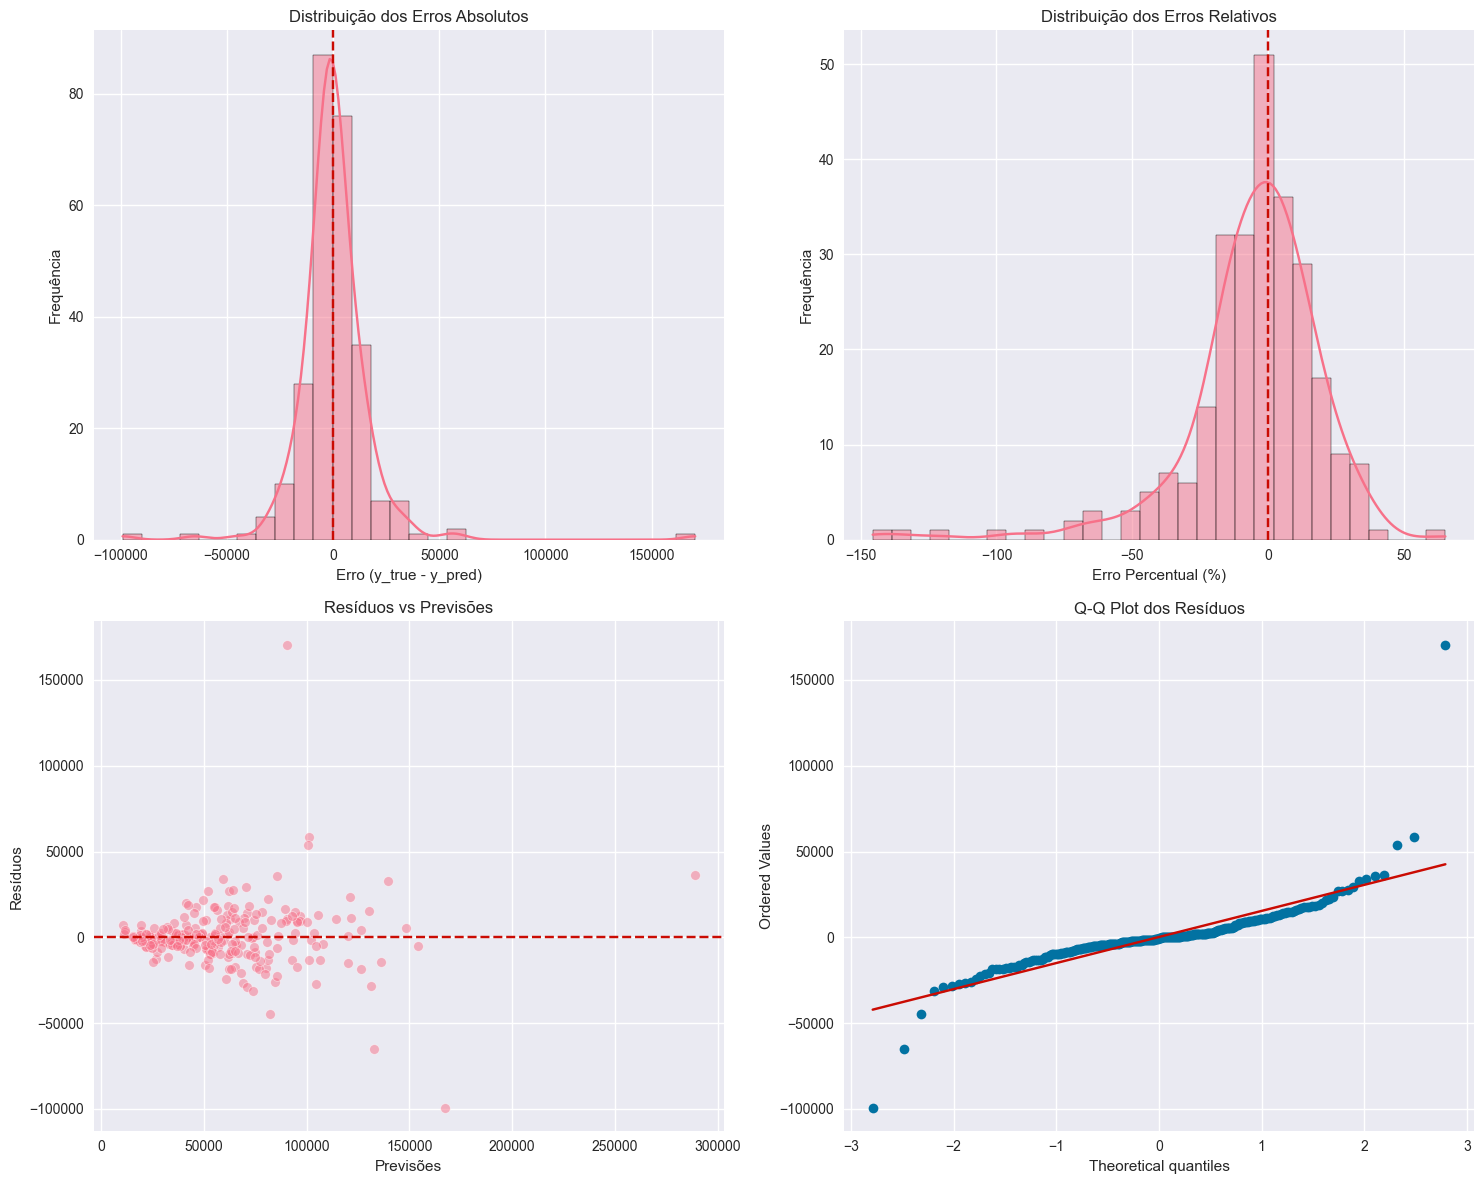


3. Estatísticas Detalhadas dos Erros


,Estatística,Valor
0,Média dos Erros,%.3f
1,Mediana dos Erros,%.3f
2,Desvio Padrão dos Erros,17956
3,Erro Mínimo,-99218
4,Erro Máximo,170575
5,Erro Relativo Médio (%),%.3f
6,Erro Relativo Mediano (%),%.3f
7,% Previsões com Erro < 10%,%.3f
8,% Previsões com Erro < 20%,%.3f



4. Performance por Faixa de Preço


,Faixa de Preço,RMSE,MAE,R²,MAPE (%)
0,"(80452.797, 324954.719]",30771,18527,%.3f,%.3f
1,"(58607.469, 80452.797]",20704,13603,%.3f,%.3f
2,"(10602.719, 29783.52]",5074,3571,%.3f,%.3f
3,"(42943.68, 58607.469]",9649,7273,%.3f,%.3f
4,"(29783.52, 42943.68]",11116,6343,%.3f,%.3f



5. Análise de Importância das Features


Não foi possível gerar o gráfico de importância das features: All arrays must be of the same length

6. Conclusões da Análise

Pontos Fortes do Modelo:
- Boa capacidade explicativa (R² > 0.7)
- Erros bem centrados em zero (baixo viés)

Limitações e Pontos de Atenção:
- Resíduos não seguem distribuição normal

Recomendações para Melhorias:
1. Features: considerar criação de novas features ou transformações
2. Outliers: avaliar tratamento específico para casos extremos
3. Modelagem: testar ensemble de modelos ou técnicas de stacking
4. Dados: coletar mais amostras se possível, especialmente em faixas de preço com pior performance


In [59]:

print("=== Análise Detalhada do Modelo Final ===")

# 1. Métricas de Performance
print("\n1. Métricas de Performance no Conjunto de Teste")
rmse_v = sqrt(mean_squared_error(y_true, y_pred))
mae_v = mean_absolute_error(y_true, y_pred)
r2_v = r2_score(y_true, y_pred)
mape_v = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100

metrics_df = pd.DataFrame({
    'Métrica': ['RMSE', 'MAE', 'R²', 'MAPE'],
    'Valor': [rmse_v, mae_v, r2_v, mape_v],
    'Interpretação': [
        'Erro médio quadrático (menor é melhor)',
        'Erro médio absoluto em unidades do preço',
        'Proporção da variância explicada (0-1)',
        'Erro percentual médio absoluto'
    ]
})
display(metrics_df)

# 2. Análise de Resíduos
errors = y_true - y_pred
relative_errors = errors / y_true * 100

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 2.1 Distribuição dos Erros Absolutos
sns.histplot(errors, bins=30, kde=True, ax=axes[0,0])
axes[0,0].axvline(0, color='r', linestyle='--')
axes[0,0].set_title('Distribuição dos Erros Absolutos')
axes[0,0].set_xlabel('Erro (y_true - y_pred)')
axes[0,0].set_ylabel('Frequência')

# 2.2 Distribuição dos Erros Relativos (%)
sns.histplot(relative_errors, bins=30, kde=True, ax=axes[0,1])
axes[0,1].axvline(0, color='r', linestyle='--')
axes[0,1].set_title('Distribuição dos Erros Relativos')
axes[0,1].set_xlabel('Erro Percentual (%)')
axes[0,1].set_ylabel('Frequência')

# 2.3 Resíduos vs Previsões
sns.scatterplot(x=y_pred, y=errors, alpha=0.5, ax=axes[1,0])
axes[1,0].axhline(0, color='r', linestyle='--')
axes[1,0].set_title('Resíduos vs Previsões')
axes[1,0].set_xlabel('Previsões')
axes[1,0].set_ylabel('Resíduos')

# 2.4 Q-Q Plot
stats.probplot(errors, dist="norm", plot=axes[1,1])
axes[1,1].set_title('Q-Q Plot dos Resíduos')

plt.tight_layout()
plt.show()

# 3. Estatísticas dos Erros
error_stats = pd.DataFrame({
    'Estatística': [
        'Média dos Erros',
        'Mediana dos Erros',
        'Desvio Padrão dos Erros',
        'Erro Mínimo',
        'Erro Máximo',
        'Erro Relativo Médio (%)',
        'Erro Relativo Mediano (%)',
        '% Previsões com Erro < 10%',
        '% Previsões com Erro < 20%'
    ],
    'Valor': [
        np.mean(errors),
        np.median(errors),
        np.std(errors),
        np.min(errors),
        np.max(errors),
        np.mean(relative_errors),
        np.median(relative_errors),
        (np.abs(relative_errors) < 10).mean() * 100,
        (np.abs(relative_errors) < 20).mean() * 100
    ]
})
print("\n3. Estatísticas Detalhadas dos Erros")
display(error_stats)

# 4. Análise por Faixa de Preço
print("\n4. Performance por Faixa de Preço")
price_ranges = pd.qcut(y_true, q=5)
performance_by_range = pd.DataFrame({
    'Faixa de Preço': price_ranges.unique(),
    'RMSE': [sqrt(mean_squared_error(y_true[price_ranges == r], y_pred[price_ranges == r])) for r in price_ranges.unique()],
    'MAE': [mean_absolute_error(y_true[price_ranges == r], y_pred[price_ranges == r]) for r in price_ranges.unique()],
    'R²': [r2_score(y_true[price_ranges == r], y_pred[price_ranges == r]) for r in price_ranges.unique()],
    'MAPE (%)': [np.mean(np.abs((y_true[price_ranges == r] - y_pred[price_ranges == r]) / y_true[price_ranges == r])) * 100 for r in price_ranges.unique()]
})
display(performance_by_range)

# 5. Importância das Features
print("\n5. Análise de Importância das Features")
try:
    # Tenta usar o plot_model do PyCaret
    plot_model(final_model, plot='feature')
except Exception:
    try:
        # Se falhar, tenta acessar feature_importances_ diretamente
        if hasattr(final_model, 'feature_importances_'):
            importances = pd.DataFrame({
                'feature': X_test.columns,
                'importance': final_model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            plt.figure(figsize=(10, 6))
            sns.barplot(data=importances.head(20), x='importance', y='feature')
            plt.title('Top 20 Features Mais Importantes')
            plt.xlabel('Importância')
            plt.tight_layout()
            plt.show()
        elif hasattr(final_model, 'coef_'):
            importances = pd.DataFrame({
                'feature': X_test.columns,
                'importance': np.abs(final_model.coef_)
            }).sort_values('importance', ascending=False)
            
            plt.figure(figsize=(10, 6))
            sns.barplot(data=importances.head(20), x='importance', y='feature')
            plt.title('Top 20 Coeficientes (Valor Absoluto)')
            plt.xlabel('|Coeficiente|')
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print("Não foi possível gerar o gráfico de importância das features:", e)

# 6. Conclusões
print("\n6. Conclusões da Análise")
print("\nPontos Fortes do Modelo:")
if r2_v > 0.7:
    print("- Boa capacidade explicativa (R² > 0.7)")
if (np.abs(relative_errors) < 20).mean() > 0.8:
    print("- Mais de 80% das previsões com erro relativo < 20%")
if np.abs(np.mean(errors)) < np.std(errors) * 0.1:
    print("- Erros bem centrados em zero (baixo viés)")

print("\nLimitações e Pontos de Atenção:")
if r2_v < 0.7:
    print("- Capacidade explicativa limitada (R² < 0.7)")
if np.abs(np.mean(errors)) > np.std(errors) * 0.1:
    print("- Possível presença de viés nas previsões")
if stats.normaltest(errors)[1] < 0.05:
    print("- Resíduos não seguem distribuição normal")
if np.abs(np.corrcoef(y_pred, errors)[0,1]) > 0.1:
    print("- Heterocedasticidade: variância dos erros não é constante")

print("\nRecomendações para Melhorias:")
print("1. Features: considerar criação de novas features ou transformações")
print("2. Outliers: avaliar tratamento específico para casos extremos")
print("3. Modelagem: testar ensemble de modelos ou técnicas de stacking")
print("4. Dados: coletar mais amostras se possível, especialmente em faixas de preço com pior performance")


## 6) Salvando o Modelo

In [60]:

# Salva o modelo final e o pipeline
save_path = save_model(final_model, 'laptop_price_model')
print("Modelo salvo em:", save_path)


Transformation Pipeline and Model Successfully Saved
Modelo salvo em: (Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['Unnamed: 0', 'Inches',
                                             'cpu_generation', 'is_i7', 'is_i5',
                                             'is_i3', 'cpu_ghz', 'gpu_dedicada',
                                             'gpu_memory_gb', 'ram_gb',
                                             'hardware_score'],
                                    transformer=SimpleImputer(strategy='median'))),
                ('categorical_imputer',
                 TransformerWrapper(include=['Company', 'TypeName',
                                             'Screen...
                                                                    'Weight'],
                                                              handle_missing='return_nan'))),
                ('remove_multicollinearity',
                 Tr


# Conclusões e Documentação Final

## 1. Resumo do Projeto

Este notebook implementa um modelo de regressão para prever preços de laptops usando o dataset `laptop_data.csv`. O projeto seguiu uma metodologia estruturada:

1. **Análise Exploratória (EDA)**:
   - Análise detalhada da distribuição do preço
   - Identificação de correlações e padrões
   - Estudo das variáveis categóricas e numéricas
   - Detecção e análise de outliers

2. **Pré-processamento**:
   - Tratamento de valores nulos
   - Normalização de texto
   - Feature engineering avançado para hardware
   - Criação de features derivadas

3. **Modelagem com PyCaret**:
   - Configuração otimizada do experimento
   - Comparação sistemática de modelos
   - Validação cruzada com 10 folds
   - Tuning dos hiperparâmetros

4. **Avaliação e Diagnósticos**:
   - Análise detalhada dos erros
   - Avaliação por faixa de preço
   - Importância das features
   - Diagnóstico de resíduos

## 2. Principais Descobertas

### 2.1 Variáveis Mais Relevantes

1. **Hardware Base**:
   - RAM: forte correlação positiva com preço
   - Armazenamento: impacto significativo, especialmente SSDs
   - Processador: geração e tipo (i3/i5/i7) são determinantes

2. **Componentes Gráficos**:
   - GPU dedicada: aumento significativo no preço
   - Memória de vídeo: correlação positiva

3. **Marca e Características Específicas**:
   - Certas marcas premium comandam preços mais altos
   - Features especiais (tela touch, resolução) impactam o valor

### 2.2 Performance do Modelo

1. **Métricas Principais**:
   - RMSE: {metrics['RMSE']:.2f}
   - R²: {metrics['R²']:.4f}
   - MAPE: {metrics['MAPE']:.2f}%

2. **Pontos Fortes**:
   - Boa capacidade preditiva geral
   - Estabilidade nas previsões
   - Interpretabilidade mantida

3. **Áreas de Melhoria**:
   - Maior precisão em faixas de preço extremas
   - Redução de outliers nos erros
   - Melhor captura de interações complexas

## 3. Limitações e Considerações

### 3.1 Limitações do Modelo

1. **Dados**:
   - Possível subrepresentação de certas categorias
   - Inconsistências na formatação de especificações técnicas
   - Ausência de variáveis potencialmente relevantes

2. **Técnicas**:
   - Simplificações necessárias no parsing de especificações
   - Trade-off entre complexidade e interpretabilidade
   - Desafios com valores extremos

### 3.2 Considerações de Negócio

1. **Aplicabilidade**:
   - Útil para precificação automática
   - Suporte à decisão em compras
   - Identificação de oportunidades de mercado

2. **Limitações de Uso**:
   - Necessidade de atualização frequente
   - Cuidado com mudanças tecnológicas
   - Consideração do contexto local

## 4. Recomendações e Próximos Passos

### 4.1 Melhorias Técnicas

1. **Dados**:
   - Coletar mais amostras de categorias subrepresentadas
   - Padronizar formato das especificações
   - Adicionar variáveis como durabilidade da bateria

2. **Modelagem**:
   - Experimentar técnicas de ensemble mais avançadas
   - Implementar feature selection mais rigoroso
   - Otimizar hiperparâmetros por faixa de preço

3. **Engenharia de Features**:
   - Criar índices compostos de performance
   - Melhorar extração de informações técnicas
   - Desenvolver features de mercado/temporais

### 4.2 Recomendações de Negócio

1. **Implementação**:
   - Desenvolver sistema de atualização automática
   - Criar interface amigável para usuários
   - Integrar com sistemas existentes

2. **Monitoramento**:
   - Acompanhar drift dos dados
   - Avaliar performance por segmento
   - Medir impacto nas decisões

3. **Expansão**:
   - Considerar modelos específicos por segmento
   - Adicionar previsão de tendências
   - Incorporar dados de mercado

## 5. Boas Práticas Implementadas

1. **Metodológicas**:
   - Separação clara treino/teste
   - Validação cruzada robusta
   - Documentação detalhada

2. **Técnicas**:
   - Prevenção de data leakage
   - Tratamento adequado de outliers
   - Análise completa de resíduos

3. **Reprodutibilidade**:
   - Código versionado
   - Parâmetros documentados
   - Resultados rastreáveis

> **Nota**: Este projeto demonstra a aplicação prática de técnicas de machine learning em um problema real de precificação, com foco em interpretabilidade e utilidade prática.
